# Comparison of SGD, LDHD and KFAD in Neural Networks
_Neural Network implemented from scratch to visualize the differences between SGD, LDHD and KFAD optimizers._

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import json

## Python Class Layer

In [2]:
class Layer:
    def __init__(self, input_size, output_size):
        """
        Initiates the matrices with the weights and biases for a layer with input_size input neurons and output_size 
        output neurons with random samples from a uniform distribution over [-0.5,0.5)]
        """
        # weights and biases
        self.weights = np.random.normal(size=(input_size, output_size))
        self.bias = np.random.normal(size=(1,output_size))
        self.weights_reset = self.weights
        self.bias_reset = self.bias
        
        # gradient errors
        self.output_error = np.zeros((1,input_size)) # initialize output error gradient to 0 for each neuron going outwards
        self.weights_error = np.zeros((input_size, output_size))
        self.bias_error = np.zeros((1,output_size))
        
        # y prediction
        self.y_prediction = None # from previous layer
        
        # p weights and p bias - only used for LDHD and KFAD
        scaler_hyperparameter = 0.01
        self.p_weights = scaler_hyperparameter*np.random.normal(size=self.weights.shape)
        self.p_bias = scaler_hyperparameter*np.random.normal(size=self.bias.shape)
        self.p_weights_reset = self.p_weights
        self.p_bias_reset = self.p_bias
        
        # e (xi) - only used for KFAD
        self.e = 0
        
        
    def forward_pass(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output
    
    def back_propagation(self, output_error_grad):
        #output_error_grad = output_error_grad.reshape(self.output_shape)
        input_error_grad = np.dot(output_error_grad, np.transpose(self.weights))
        weights_error_grad = np.dot(np.transpose(self.input), output_error_grad)
        bias_error_grad = output_error_grad
        return input_error_grad, weights_error_grad, bias_error_grad

    def SGD(self, learning_rate):
        """
        Updates weights and biases using (Stochastic) Gradient Descent.
        """
        self.weights -= learning_rate*self.weights_error
        self.bias -= learning_rate*self.bias_error
        
    def LDHD(self, timestep, gamma, part):
        """
        Updates weights and biases using Linearly Dissipated Hamiltonian Dynamics.
        Symmetric integrator used for splitting method: BADAB (half a timestep used 
        for each A and B step and whole timestep used per D step)
        """
        def splitA_LDHD(x0, p0, timestep):
            x1 = x0+ timestep*p0
            p1 = p0
            return x1, p1

        def splitB_LDHD(x0, p0, F, timestep):
            # Make sure that F is minus the gradient!
            x1 = x0
            p1 = p0 + timestep*F
            return x1, p1

        def splitD_LDHD(x0, p0, timestep, gamma):
            x1 = x0
            p1 = np.exp(-timestep*gamma)*p0
            return x1, p1
        
        # Implementing BADAB_step (symmetric integrator for LDHD)
        # Note that this symmetric integrator requires to update weights and biases simultaneously at each substep
        # as it will calculate another forward_pass and back_prop towards the end before we finish BADAB.
        # This is different to STG where you can update them independently
        
        if part == 0:
            # B - half a timestep
            self.weights, self.p_weights = splitB_LDHD(self.weights, self.p_weights, -self.weights_error, timestep/2)
            self.bias, self.p_bias = splitB_LDHD(self.bias, self.p_bias, -self.bias_error, timestep/2)
        
            # A - half a timestep
            self.weights, self.p_weights = splitA_LDHD(self.weights, self.p_weights, timestep/2)
            self.bias, self.p_bias = splitA_LDHD(self.bias, self.p_bias, timestep/2)
        
            # D
            self.weights, self.p_weights = splitD_LDHD(self.weights, self.p_weights, timestep, gamma)
            self.bias, self.p_bias = splitD_LDHD(self.bias, self.p_bias, timestep, gamma)
        
            # A - half a timestep
            self.weights, self.p_weights = splitA_LDHD(self.weights, self.p_weights, timestep/2)
            self.bias, self.p_bias = splitA_LDHD(self.bias, self.p_bias, timestep/2)
        
        else:
            # B - half a timestep 
            self.weights, self.p_weights = splitB_LDHD(self.weights, self.p_weights, -self.weights_error, timestep/2)
            self.bias, self.p_bias = splitB_LDHD(self.bias, self.p_bias, -self.bias_error, timestep/2)
        
        # BADAB COMPLETED!
        return # output, weights and biases to use for other layers in Neural Network class are stored within layer
        
        
    def KFAD(self, timestep, gamma, alpha, mu, part):
        """
        Updates weights and biases using Kinetic Friction Adaptive Descent.
        Symmetric integrator used for splitting method: DABCBAD (half a timestep used
        for each A, B and D step and a whole timestep used per C step)
        """
        def splitA_KFAD(x0,p0,e0, timestep):
            x1 = x0+ timestep*p0
            p1 = p0
            e1 = e0
            return x1, p1, e1

        def splitB_KFAD(x0,p0,e0, timestep, F):
            x1 = x0
            p1 = p0 + timestep*F
            e1 = e0
            return x1, p1, e1

        def splitD_KFAD(x0,p0,e0, timestep, gamma):
            x1 = x0
            p1 = np.exp(-timestep*gamma)*p0
            e1 = e0
            return x1, p1, e1

        def splitC_KFAD(x0,p0,e0, timestep, alpha, mu):
            n,m =p0.shape 
            A = np.eye(n)
            x1 = x0
            p1 = p0 - (timestep/2)*e0*A@p0
            e1 = np.exp(-alpha*(timestep/2)) + ((1-np.exp(-alpha*timestep))*(linalg.norm(p1)**2))/(mu*alpha)
            p1 = p1 - (timestep/2)*e1*A@p1
            return x1, p1, e1
        
        # Implementing DABCBAD step (symmetric integrator for KFAD)
        # Note that this symmetric integrator requires to update weights and biases simultaneously at each substep
        # as it will calculate another forward_pass and back_prop towards the end before we finish BADAB.
        
        if part == 0:
            # D - half a timestep
            self.weights, self.p_weights, self.e = splitD_KFAD(self.weights, self.p_weights,self.e, timestep/2, gamma)
            self.bias, self.p_bias, self.e = splitD_KFAD(self.bias, self.p_bias,self.e, timestep/2, gamma)
        
            # A - half a timestep
            self.weights, self.p_weights, self.e = splitA_KFAD(self.weights, self.p_weights, self.e,timestep/2)
            self.bias, self.p_bias, self.e = splitA_KFAD(self.bias, self.p_bias, self.e,timestep/2)
        
        elif part == 1:
            # B - half a timestep
            self.weights, self.p_weights, self.e = splitB_KFAD(self.weights, self.p_weights,self.e, timestep/2, -self.weights_error)
            self.bias, self.p_bias, self.e = splitB_KFAD(self.bias, self.p_bias, self.e,timestep/2, -self.bias_error)
        
            # C
            self.weights, self.p_weights, self.e = splitC_KFAD(self.weights, self.p_weights,self.e,timestep, alpha, mu)
            self.bias, self.p_bias, self.e = splitC_KFAD(self.bias, self.p_bias, self.e,timestep, alpha, mu)
        
        else:
            # B - half a timestep
            self.weights, self.p_weights, self.e = splitB_KFAD(self.weights, self.p_weights,self.e, timestep/2, -self.weights_error)
            self.bias, self.p_bias, self.e = splitB_KFAD(self.bias, self.p_bias, self.e,timestep/2, -self.bias_error)
        
            # A - half a timestep
            self.weights, self.p_weights, self.e = splitA_KFAD(self.weights, self.p_weights, self.e,timestep/2)
            self.bias, self.p_bias, self.e = splitA_KFAD(self.bias, self.p_bias, self.e,timestep/2)
        
            # D - half a timestep 2
            self.weights, self.p_weights, self.e = splitD_KFAD(self.weights, self.p_weights,self.e, timestep/2, gamma)
            self.bias, self.p_bias, self.e = splitD_KFAD(self.bias, self.p_bias,self.e, timestep/2, gamma)
        
        # DABCBAD COMPLETED!
        return # output, weights and biases to use for other layers in Neural Network class are stored within layer

## Python Class Activation Layer

In [3]:
class ActivationLayer:
    def __init__(self, activation_function, activation_prime):
        self.activation = activation_function
        self.activation_prime = activation_prime
        self.y_prediction = None
        
    def forward_pass(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output
    
    def back_propagation(self, output_error_grad):
        #output_error_grad = output_error_grad.reshape(self.output_shape)
        input_error_grad = np.multiply(output_error_grad, self.activation_prime(self.input))
        return input_error_grad

## Python Class Neural Network

In [4]:
class NeuralNetwork:
    def __init__(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime
        self.layers = []
        
    def add_layer(self, layer):
        self.layers.append(layer)
        return
        
    def error_gradients_in_batch(self,X_train, y_train, batch_indices):
        no = len(X_train) # number of observations
        for i in batch_indices:
            y_prediction = X_train[i]
            for layer in self.layers:
                layer.y_prediction_previous = y_prediction
                y_prediction = layer.forward_pass(y_prediction)
                
            output_error_observation = self.loss_prime(y_train[i], y_prediction)#, layer.output
            
            for layer in self.layers:
                if isinstance(layer,Layer):
                    layer.output_shape = layer.output_error.shape
                    
            for layer in reversed(self.layers):
                if isinstance(layer, Layer):
                    output_error_layer, weights_error_layer, bias_error_layer = layer.back_propagation(output_error_observation)
                    layer.output_error += output_error_layer
                    layer.weights_error += weights_error_layer
                    layer.bias_error += bias_error_layer
                else:
                    output_error_observation = layer.back_propagation(output_error_observation)
        # gradient error scaling
        for layer in self.layers:
            if isinstance(layer, Layer):
                layer.output_error = (no/batch_size)*layer.output_error
                layer.weights_error = (no/batch_size)*layer.weights_error
                layer.bias_error = (no/batch_size)*layer.bias_error
        return
        
        
    def fit(self, X_train, y_train, Nsteps, batch_size, learning_rate, optimizer, extra_parameters=[None,None,None]):
        """
        Input: - X_train -> training data
               - y_train -> training label
               - Nsteps -> number of epochs or steps taken to fit data
               - batch_size -> size of training batch per step
               - learning_rate -> learning rate/timestep
               - optimizer -> 'SGD', 'LDHD' or 'KFAD'
               - extra_parameters -> *optional* list containing the extra parameters (3) needed if LDHD or KFAD is selected
                 the list is in the following order: [gamma, alpha, mu].
                 Ex: if LDHD is selected only gamma is required so the appropriate entry would be 
                 [gamma0, None, None], whereas for KFAD you would input all values.
                 If no values are inputed and KFAD or LDHD are used, the parameter values are arbitrarily set or fixed.
                 The p_weights and p_bias parameters are randomly initialized for each layer (in the Layer class).
        """
        # length of training set
        no = len(X_train) # number of observations
        x_len = X_train.size
        
        # PARAMETERS
        # initializing extra parameters
        initiliazed_parameters = [1, 1, 1]
        
        # updating initialized parameters with user inputed parameters if optional extra_parameters list was inputed
        for k in range(len(initiliazed_parameters)):
            if extra_parameters[k] != None:
                initiliazed_parameters[k] = extra_parameters[k]
                     
        gamma, alpha, mu = initiliazed_parameters
                
        for j in range(Nsteps):
            batch_indices = np.random.randint(0,no, size=batch_size) 
            self.error_gradients_in_batch(X_train, y_train, batch_indices)
            
            for layer in reversed(self.layers):
                if isinstance(layer, Layer):
                    if optimizer == 'SGD':
                        layer.SGD(learning_rate)
                    
                    elif optimizer == 'KFAD':
                        part = 0
                        layer.KFAD(learning_rate, gamma, alpha, mu, part)
                        self.error_gradients_in_batch(X_train, y_train, batch_indices)
                        part +=1
                        layer.KFAD(learning_rate, gamma, alpha, mu, part)
                        part +=1
                        layer.KFAD(learning_rate, gamma, alpha, mu, part)
                        self.error_gradients_in_batch(X_train, y_train, batch_indices)
        
                    else:
                        part = 0
                        layer.LDHD(learning_rate, gamma, part)
                        self.error_gradients_in_batch(X_train, y_train, batch_indices)
                        part +=1
                        layer.LDHD(learning_rate, gamma, part)
                        self.error_gradients_in_batch(X_train, y_train, batch_indices)
                        #part +=1
                        #layer.LDHD(learning_rate, gamma, part)
    
    def reset(self):
        for layer in self.layers:
            if isinstance(layer,Layer):
                layer.weights = layer.weights_reset
                layer.bias = layer.bias_reset
                layer.p_weights = layer.p_weights_reset
                layer.p_bias = layer.p_bias_reset
    
    def predict(self, X_test):
        # number of predictions
        no = len(X_test)
        
        # predictions
        predictions = np.zeros(no)
        for i in range(no):
            prediction = X_test[i]
            for layer in self.layers:
                prediction = layer.forward_pass(prediction)
            predictions[i] = prediction
        return predictions.reshape((no,1,1))
    
    def summary(self):
        print("Summary:\n")
        no_of_layers = len(self.layers)
        for i in range(no_of_layers):
            print(f"Layer {i+1}\n")
            if isinstance(self.layers[i], Layer) == True:
                print(f"Weights: \n", self.layers[i].weights, "\n")
                print(f"Biases: ", self.layers[i].bias, "\n\n")
            else:
                print("Activation layer.\n\n")

## Loss Functions

In [5]:
# mean squared error
def MSE(y_true, y_prediction):
    return np.mean(np.power(y_true-y_prediction, 2))

def MSE_prime(y_true, y_prediction):
    return (2/y_true.size)*(y_prediction-y_true)

## Activation Functions

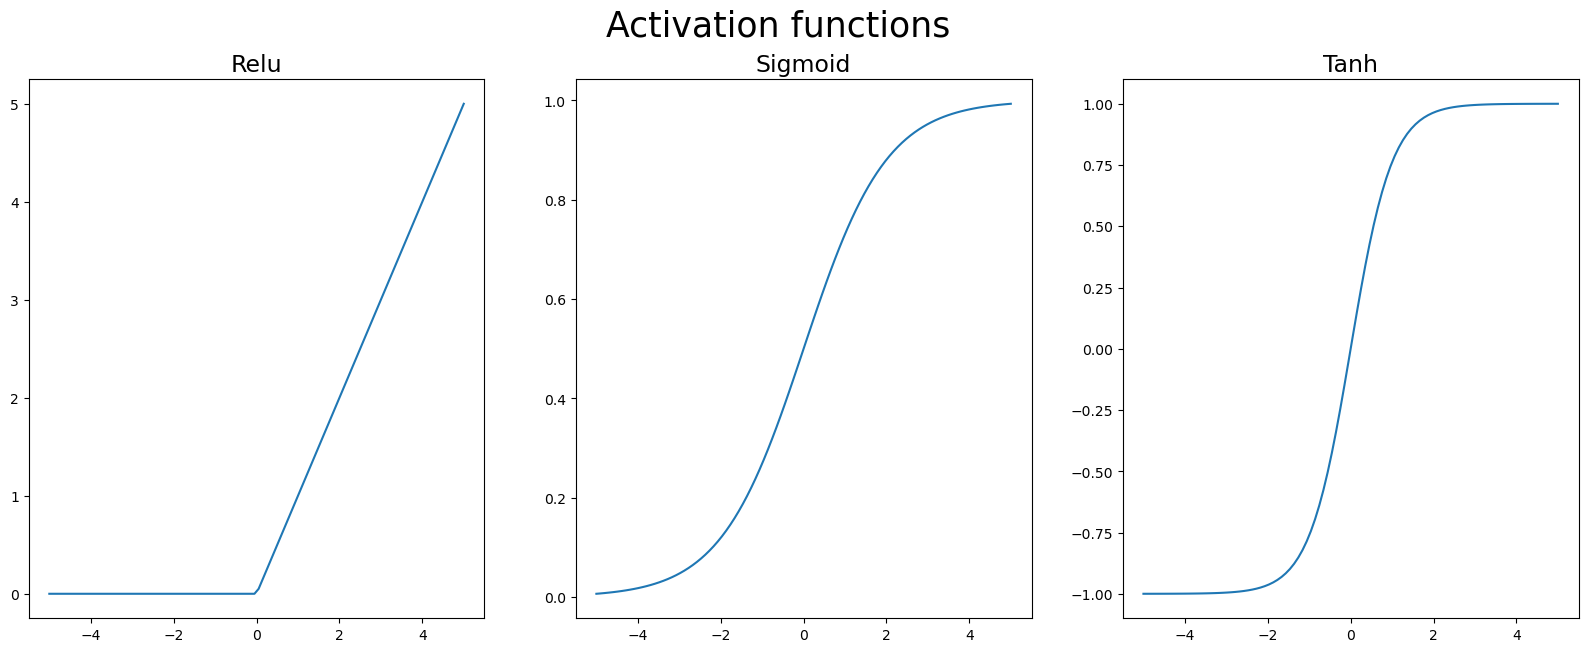

In [6]:
def relu(Z):
    return Z*(Z>0)

def relu_prime(Z):
    return Z > 0 # relu is not differentiable at Z = 0, the value of the derivative at this point is set at 0 (it is very unlikely we will encounter Z = 0)
    
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_prime(Z):
    return sigmoid(Z)*(1-sigmoid(Z))

def tanh(Z):
    return np.tanh(Z)

def tanh_prime(Z):
    return 1-np.tanh(Z)**2;

# Visualizing the activation functions
figure, axes = plt.subplots(1,3, figsize=(20,7))
Z = np.linspace(-5,5,100)
axes[0].plot(Z, relu(Z))
axes[0].set_title("Relu", fontsize=17)
axes[1].plot(Z, sigmoid(Z))
axes[1].set_title("Sigmoid", fontsize=17)
axes[2].plot(Z, tanh(Z))
axes[2].set_title("Tanh", fontsize=17)
figure.suptitle("Activation functions", fontsize=25)
plt.show()

## Examples: Hyperparameter tuning when replicating the XOR gate
In this section we are searching for the best values for the hyperparameters for the timestep and $\gamma$. The hyperparameters $\mu$ and $\alpha$ are both set to 1. Moreover, the $\xi$ is set to 0 and the momenta is randomly initialized. Similarly, the total number of steps and batch size is fixed for each experiment.

In [7]:
timesteps = np.linspace(0.01,0.1,num=10)
gammas = np.linspace(0.01,1,num=10)
Xsearch_gamma, Ysearch_lr = np.meshgrid(gammas, timesteps)

In [9]:
# Fixing the hyperparameters that we are not studying
Nsteps = 1000
gamma = 0.01
batch_size = 10
# alpha = 1
# mu = 1

# the training and test set for the XOR gate
X = np.array([[[0,0]],[[0,1]],[[1,0]],[[1,1]]])
y = np.array([[0],[1],[1],[0]])

# initializing the neural network model
# The number of nodes in the hidden layer is set to 5 but this is arbitrary
xor = NeuralNetwork(MSE,MSE_prime)
xor.add_layer(Layer(2,5))
xor.add_layer(ActivationLayer(relu, relu_prime))
xor.add_layer(Layer(5,1))
xor.add_layer(ActivationLayer(sigmoid, sigmoid_prime))

# Testing all the methods
methods = ["SGD","LDHD","KFAD"]

# loss function plot
losses = {
    "SGD": np.zeros(Xsearch_gamma.shape),
    "LDHD": np.zeros(Xsearch_gamma.shape),
    "KFAD": np.zeros(Xsearch_gamma.shape)
}


np.zeros(Xsearch_gamma.shape)
for method in methods:
    for i in range(len(Xsearch_gamma)):
        # no of iterations
        gamma = gammas[i]
        for j in range(len(timesteps)):
            # the timestep or learning rate used in the network
            lr = timesteps[j]
            # reset the network
            xor.reset()
            # train the network
            xor.fit(X, y, Nsteps, batch_size, lr, method,extra_parameters=[gamma,None,None])
            # prediction
            prediction = xor.predict(X)
            # store the loss
            loss = xor.loss(y, prediction)
            losses[method][j,i] = loss

In [10]:
# the above cell takes a long time to run so we store the dictionary where we have the losses
# for the XOR replication using MSE as the loss function
losses_dict = {
    "SGD": None,
    "LDHD": None,
    "KFAD": None
}
for i in range(len(methods)):
    losses_dict[methods[i]] = losses[methods[i]].tolist()

with open("XOR_MSE_10_gamma.json", "w") as outfile: 
    json.dump(losses_dict, outfile)

# The code below is used to read in the dictionary data file for the plot
# with open("XOR_MSE_10_gamma.json", "r") as file:
#     fileData  = file.read()
#     losses = json.loads(fileData)

In [8]:
# Testing all the methods
methods = ["SGD","LDHD","KFAD"]
# The code below is used to read in the dictionary data file for the plot
with open("XOR_MSE_10_gamma.json", "r") as file:
    fileData  = file.read()
    losses = json.loads(fileData)

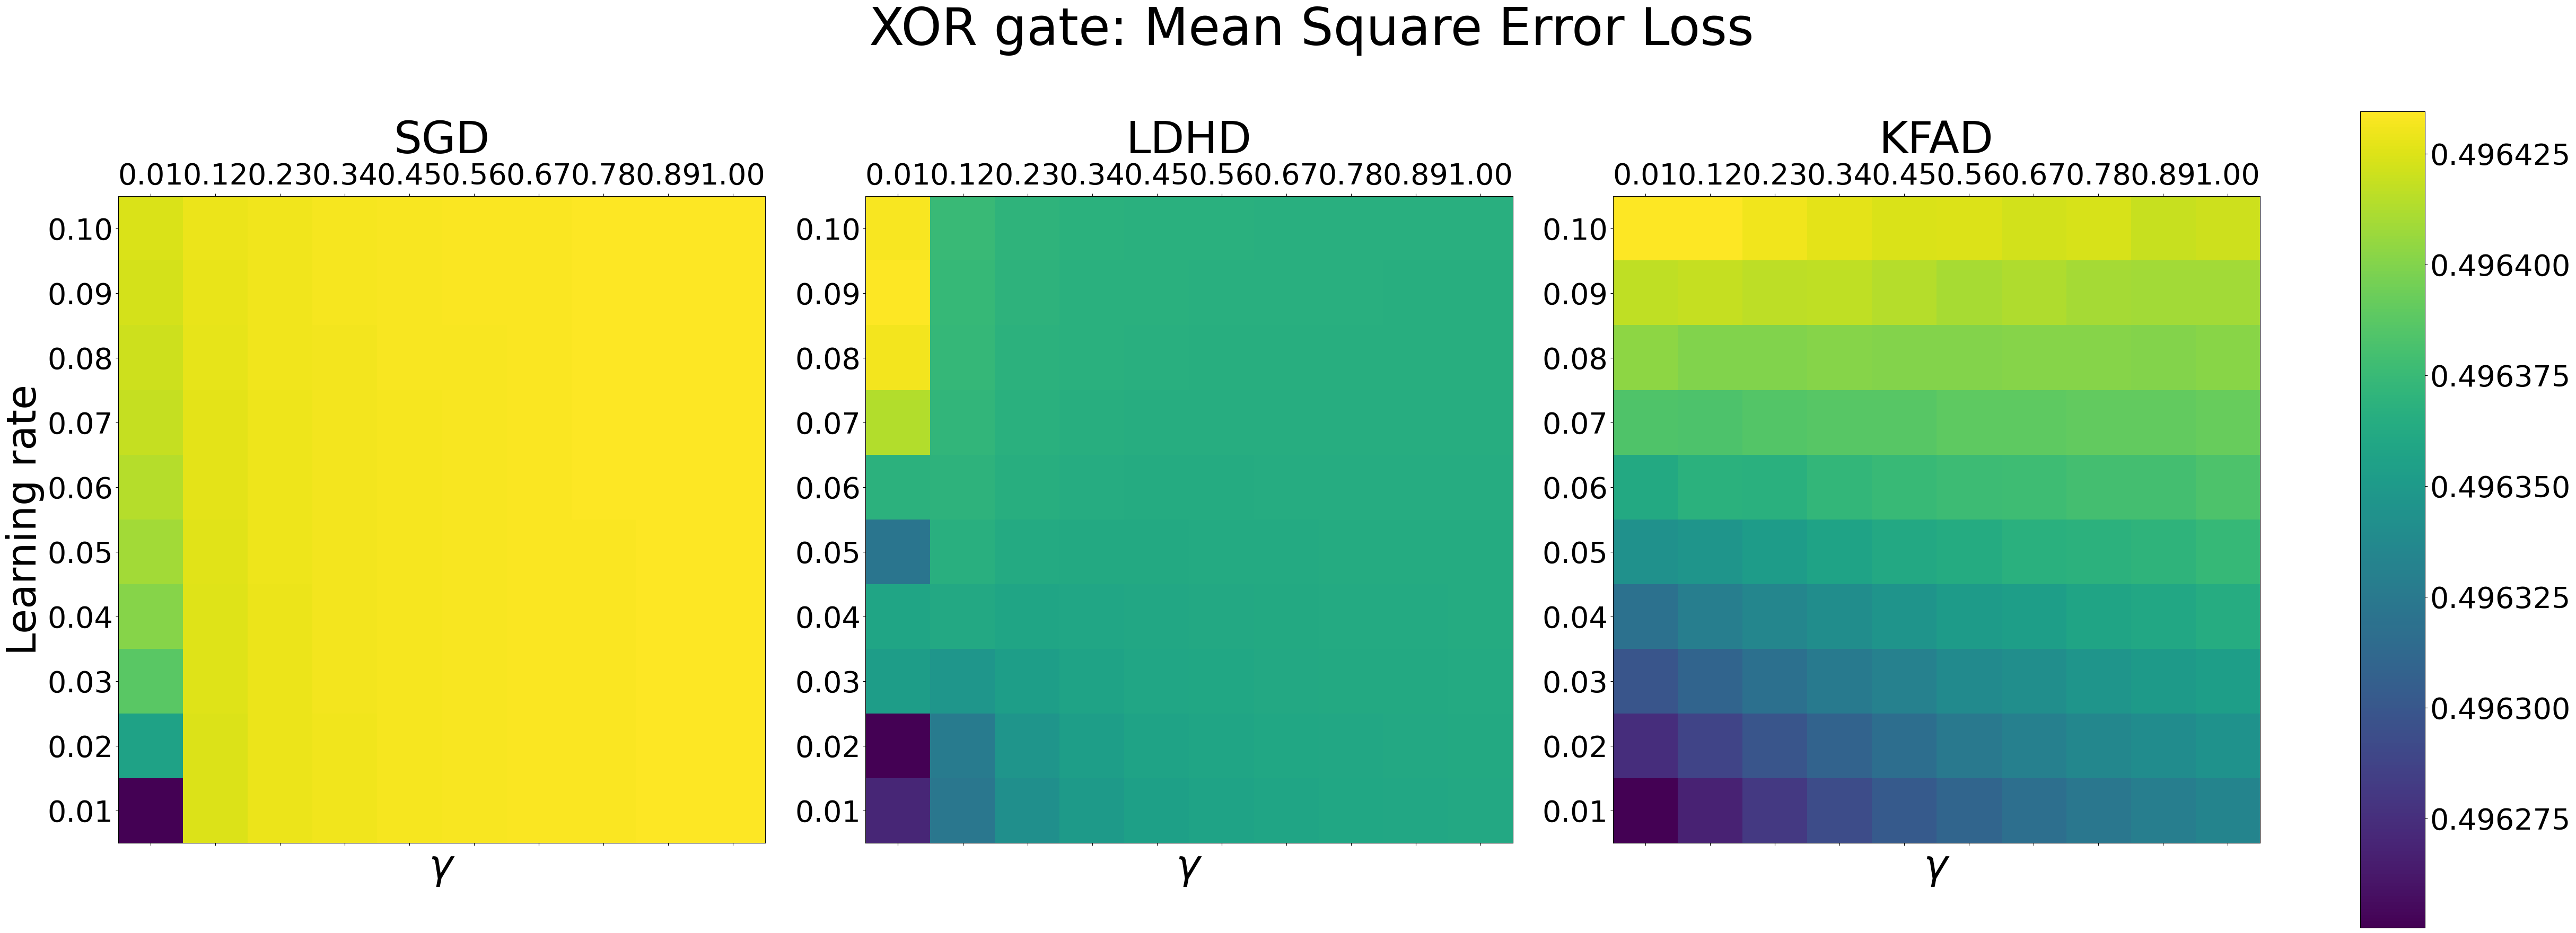

In [10]:
from matplotlib.ticker import FuncFormatter

# plot
fig, ax = plt.subplots(1,4,figsize=(60,20),width_ratios=[1,1,1,0.1])

fig.suptitle("XOR gate: Mean Square Error Loss", fontsize=70)
for k in range(len(methods)):
    method = methods[k]
    im = ax[k].matshow(losses[method],  origin='lower')
    ax[k].set_yticks(np.arange(0,len(timesteps), step=1),labels=['{:.2f}'.format(x) for x in timesteps],fontsize=40)
    ax[k].set_xlabel(r'$\gamma$', fontsize=55)
    ax[k].set_title(method, fontsize=60)
    ax[k].set_xticks(np.arange(0,len(gammas), step=1), labels=['{:.2f}'.format(x) for x in gammas], fontsize=40)
    # ax[k].set_xticklabels(['']+['{:.3f}'.format(x) for x in timesteps], rotation=80,fontsize=12)
    # ax[k].set_yticklabels(['']+['{:.3f}'.format(x) for x in gammas], fontsize=12)
ax[0].set_ylabel('Learning rate', fontsize=55)

cbar = plt.colorbar(im, ax=ax.ravel().tolist(),fraction=0.05, cax=ax[3])

cbar.ax.tick_params(labelsize=30)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(40)
def format_ticks(value, pos):
    magnitude = int(np.floor(np.log10(value)))
    scaled_value = value / 10**magnitude
    if magnitude == 0:
        return f'{scaled_value:.4f}'
    else:
        return f'{scaled_value:.4f}e{magnitude}'

# Set the custom formatter for the colorbar ticks
# cbar.formatter = FuncFormatter(format_ticks)
# cbar.update_ticks()
#plt.colorbar()
#plt.colorbar(cax)
plt.subplots_adjust(right=0.85) 
plt.savefig("figures/XOR_MSE_10_gamma.png", bbox_inches='tight', dpi=300)
plt.show()

In [37]:
timesteps = np.linspace(0.01,0.1,num=10)
iterations = np.arange(1000,11000, 1000)
Xsearch_iter, Ysearch_lr = np.meshgrid(iterations, timesteps)

In [38]:
# Fixing the hyperparameters that we are not studying
gamma = 0.01
batch_size = 10
# alpha = 1
# mu = 1

# the training and test set for the XOR gate
X = np.array([[[0,0]],[[0,1]],[[1,0]],[[1,1]]])
y = np.array([[0],[1],[1],[0]])

# initializing the neural network model
# The number of nodes in the hidden layer is set to 5 but this is arbitrary
xor = NeuralNetwork(MSE,MSE_prime)
xor.add_layer(Layer(2,5))
xor.add_layer(ActivationLayer(relu, relu_prime))
xor.add_layer(Layer(5,1))
xor.add_layer(ActivationLayer(sigmoid, sigmoid_prime))

# Testing all the methods
methods = ["SGD","LDHD","KFAD"]

# loss function plot
losses = {
    "SGD": np.zeros(Xsearch_iter.shape),
    "LDHD": np.zeros(Xsearch_iter.shape),
    "KFAD": np.zeros(Xsearch_iter.shape)
}


np.zeros(Xsearch_iter.shape)
for method in methods:
    for i in range(len(iterations)):
        # no of iterations
        Nsteps = iterations[i]
        for j in range(len(timesteps)):
            # the timestep or learning rate used in the network
            lr = timesteps[j]
            # reset the network
            xor.reset()
            # train the network
            xor.fit(X, y, Nsteps, batch_size, lr, method,extra_parameters=[gamma,None,None])
            # prediction
            prediction = xor.predict(X)
            # store the loss
            loss = xor.loss(y, prediction)
            losses[method][j,i] = loss

In [39]:
# the above cell takes a long time to run so we store the dictionary where we have the losses
# for the XOR replication using MSE as the loss function
losses_dict = {
    "SGD": None,
    "LDHD": None,
    "KFAD": None
}
for i in range(len(methods)):
    losses_dict[methods[i]] = losses[methods[i]].tolist()

with open("XOR_MSE_10_evenmoreiter.json", "w") as outfile: 
    json.dump(losses_dict, outfile)

# The code below is used to read in the dictionary data file for the plot
# with open("XOR_MSE_10.json", "r") as file:
#     fileData  = file.read()
#     losses = json.loads(fileData)

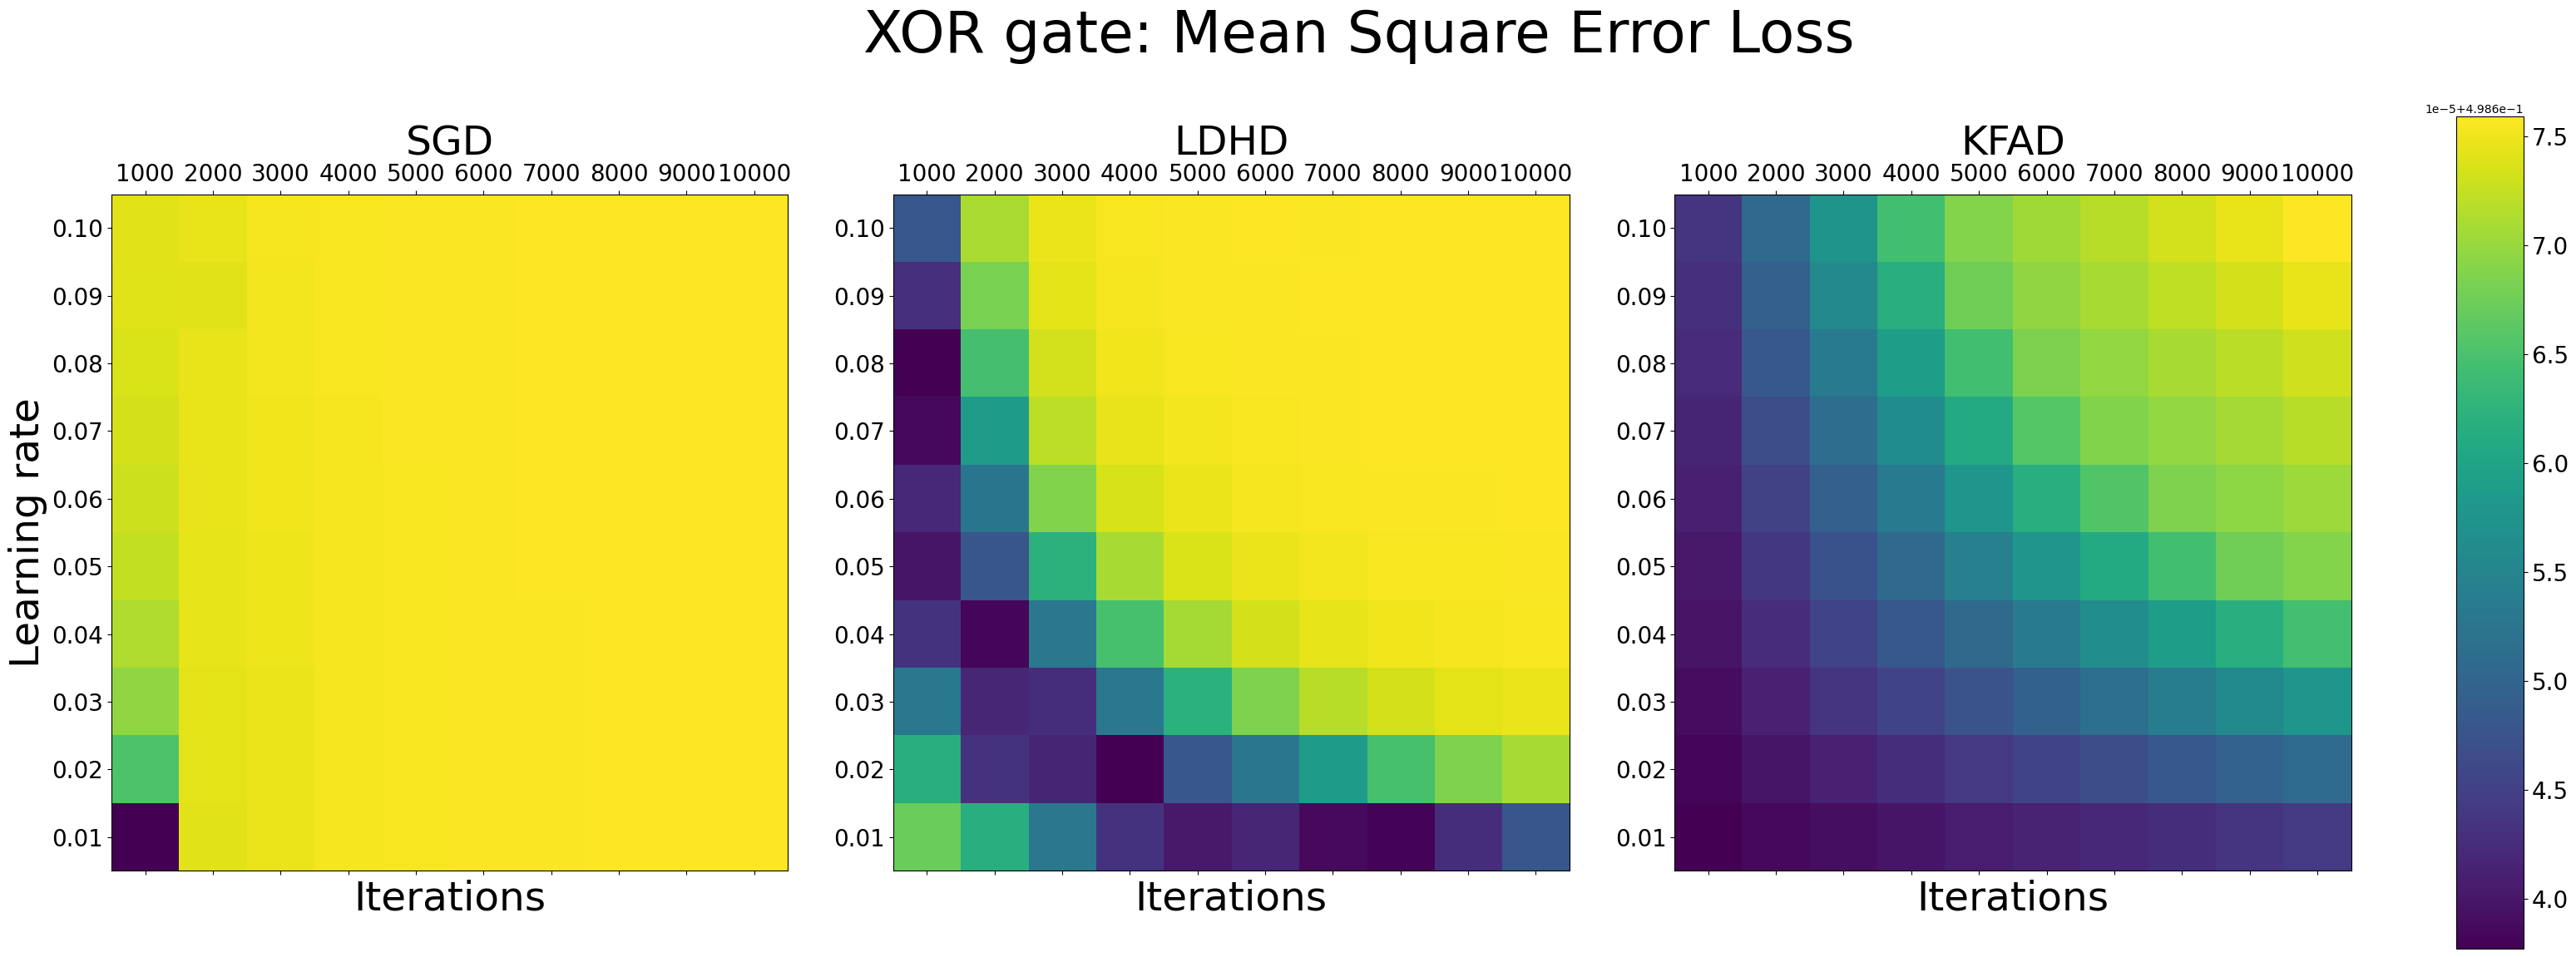

In [40]:
from matplotlib.ticker import FuncFormatter

# plot
fig, ax = plt.subplots(1,4,figsize=(40,13),width_ratios=[1,1,1,0.1])

fig.suptitle("XOR gate: Mean Square Error Loss", fontsize=50)
for k in range(len(methods)):
    method = methods[k]
    im = ax[k].matshow(losses[method],  origin='lower')
    ax[k].set_yticks(np.arange(0,len(timesteps), step=1),labels=['{:.2f}'.format(x) for x in timesteps],fontsize=20)
    ax[k].set_xlabel('Iterations', fontsize=35)
    ax[k].set_title(method, fontsize=35)
    ax[k].set_xticks(np.arange(0,len(iterations), step=1), labels=['{:.0f}'.format(x) for x in iterations], fontsize=20)
    # ax[k].set_xticklabels(['']+['{:.3f}'.format(x) for x in timesteps], rotation=80,fontsize=12)
    # ax[k].set_yticklabels(['']+['{:.3f}'.format(x) for x in gammas], fontsize=12)
ax[0].set_ylabel('Learning rate', fontsize=35)

cbar = plt.colorbar(im, ax=ax.ravel().tolist(),fraction=0.05, cax=ax[3])

cbar.ax.tick_params(labelsize=20)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
def format_ticks(value, pos):
    magnitude = int(np.floor(np.log10(value)))
    scaled_value = value / 10**magnitude
    if magnitude == 0:
        return f'{scaled_value:.4f}'
    else:
        return f'{scaled_value:.4f}e{magnitude}'

# Set the custom formatter for the colorbar ticks
# cbar.formatter = FuncFormatter(format_ticks)
# cbar.update_ticks()
#plt.colorbar()
#plt.colorbar(cax)
plt.subplots_adjust(right=0.85) 
plt.savefig("figures/XOR_MSE_10_evenmoreiter.png", bbox_inches='tight', dpi=300)
plt.show()

past

In [7]:
gammas = np.logspace(-2,1,base=10,num=16)
timesteps = np.logspace(-3,0,base=10,num=16)
Xsearch_timestep, Ysearch_gamma = np.meshgrid(timesteps,gammas)

### Replicating an XOR gate

In [26]:
Nsteps = 50




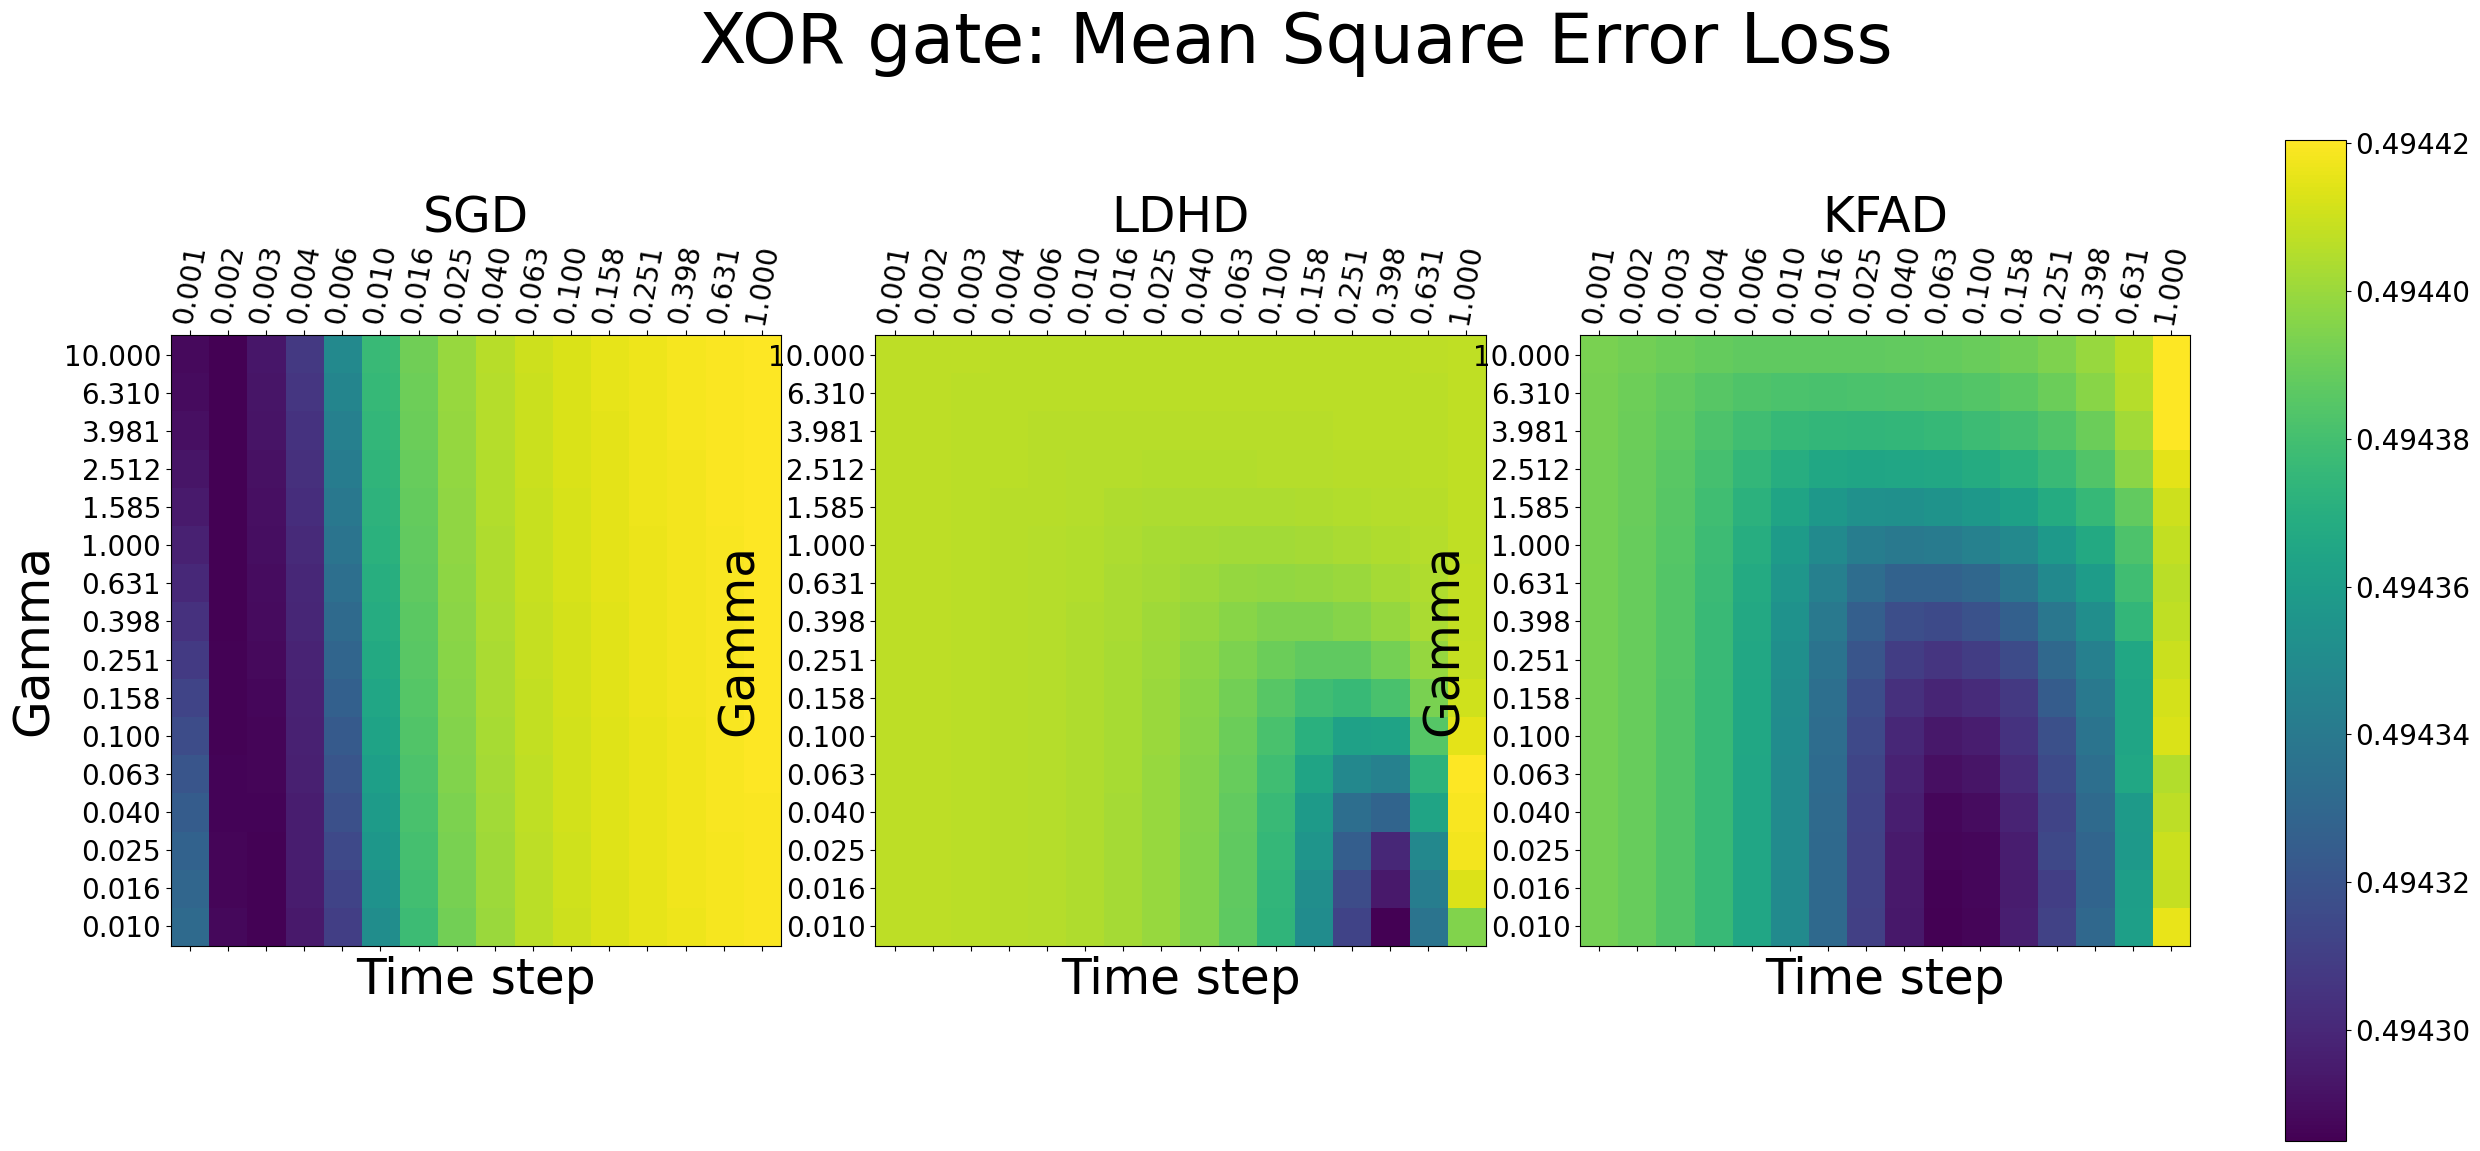

In [28]:
from matplotlib.ticker import FuncFormatter

# plot
fig, ax = plt.subplots(1,4,figsize=(30,13),width_ratios=[1,1,1,0.1])

fig.suptitle("XOR gate: Mean Square Error Loss", fontsize=50)
for k in range(len(methods)):
    method = methods[k]
    im = ax[k].matshow(losses[method],  origin='lower')
    ax[k].set_xlabel('Time step', fontsize=35)
    ax[k].set_ylabel('Gamma', fontsize=35)
    ax[k].set_title(method, fontsize=35)
    ax[k].set_xticks(np.arange(0,len(timesteps), step=1),labels=['{:.3f}'.format(x) for x in timesteps], rotation=80,fontsize=20)
    ax[k].set_yticks(np.arange(0,len(gammas), step=1), labels=['{:.3f}'.format(x) for x in gammas], fontsize=20)
    # ax[k].set_xticklabels(['']+['{:.3f}'.format(x) for x in timesteps], rotation=80,fontsize=12)
    # ax[k].set_yticklabels(['']+['{:.3f}'.format(x) for x in gammas], fontsize=12)

cbar = plt.colorbar(im, ax=ax.ravel().tolist(),fraction=0.05, cax=ax[3])

cbar.ax.tick_params(labelsize=20)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
def format_ticks(value, pos):
    magnitude = int(np.floor(np.log10(value)))
    scaled_value = value / 10**magnitude
    if magnitude == 0:
        return f'{scaled_value:.4f}'
    else:
        return f'{scaled_value:.4f}e{magnitude}'

# Set the custom formatter for the colorbar ticks
# cbar.formatter = FuncFormatter(format_ticks)
# cbar.update_ticks()
#plt.colorbar()
#plt.colorbar(cax)
plt.subplots_adjust(right=0.85) 
plt.savefig("/Users/analiacabello/Desktop/Y5/DISS/figures/XOR_MSE_16_try4.png", bbox_inches='tight', dpi=300)
plt.show()

In [52]:
# Now we choose a specific value for gamma and the time step and compare the predictions on the whole plane of each of the methods
lr = 0.06
gamma = 0.01

x_axis = np.linspace(0,1,100)
y_axis = np.linspace(0,1,100)

X_axis, Y_axis = np.meshgrid(x_axis,y_axis)

plane = np.stack((X_axis,Y_axis),axis=2)
plane = plane.reshape((10000,1,2))

# Fixing the hyperparameters that we are not studying
Nsteps = 10000
batch_size = 10
# alpha = 1
# mu = 1

# the training and test set for the XOR gate
X = np.array([[[0,0]],[[0,1]],[[1,0]],[[1,1]]])
y = np.array([[0],[1],[1],[0]])

# Testing all the methods
methods = ["SGD","LDHD","KFAD"]

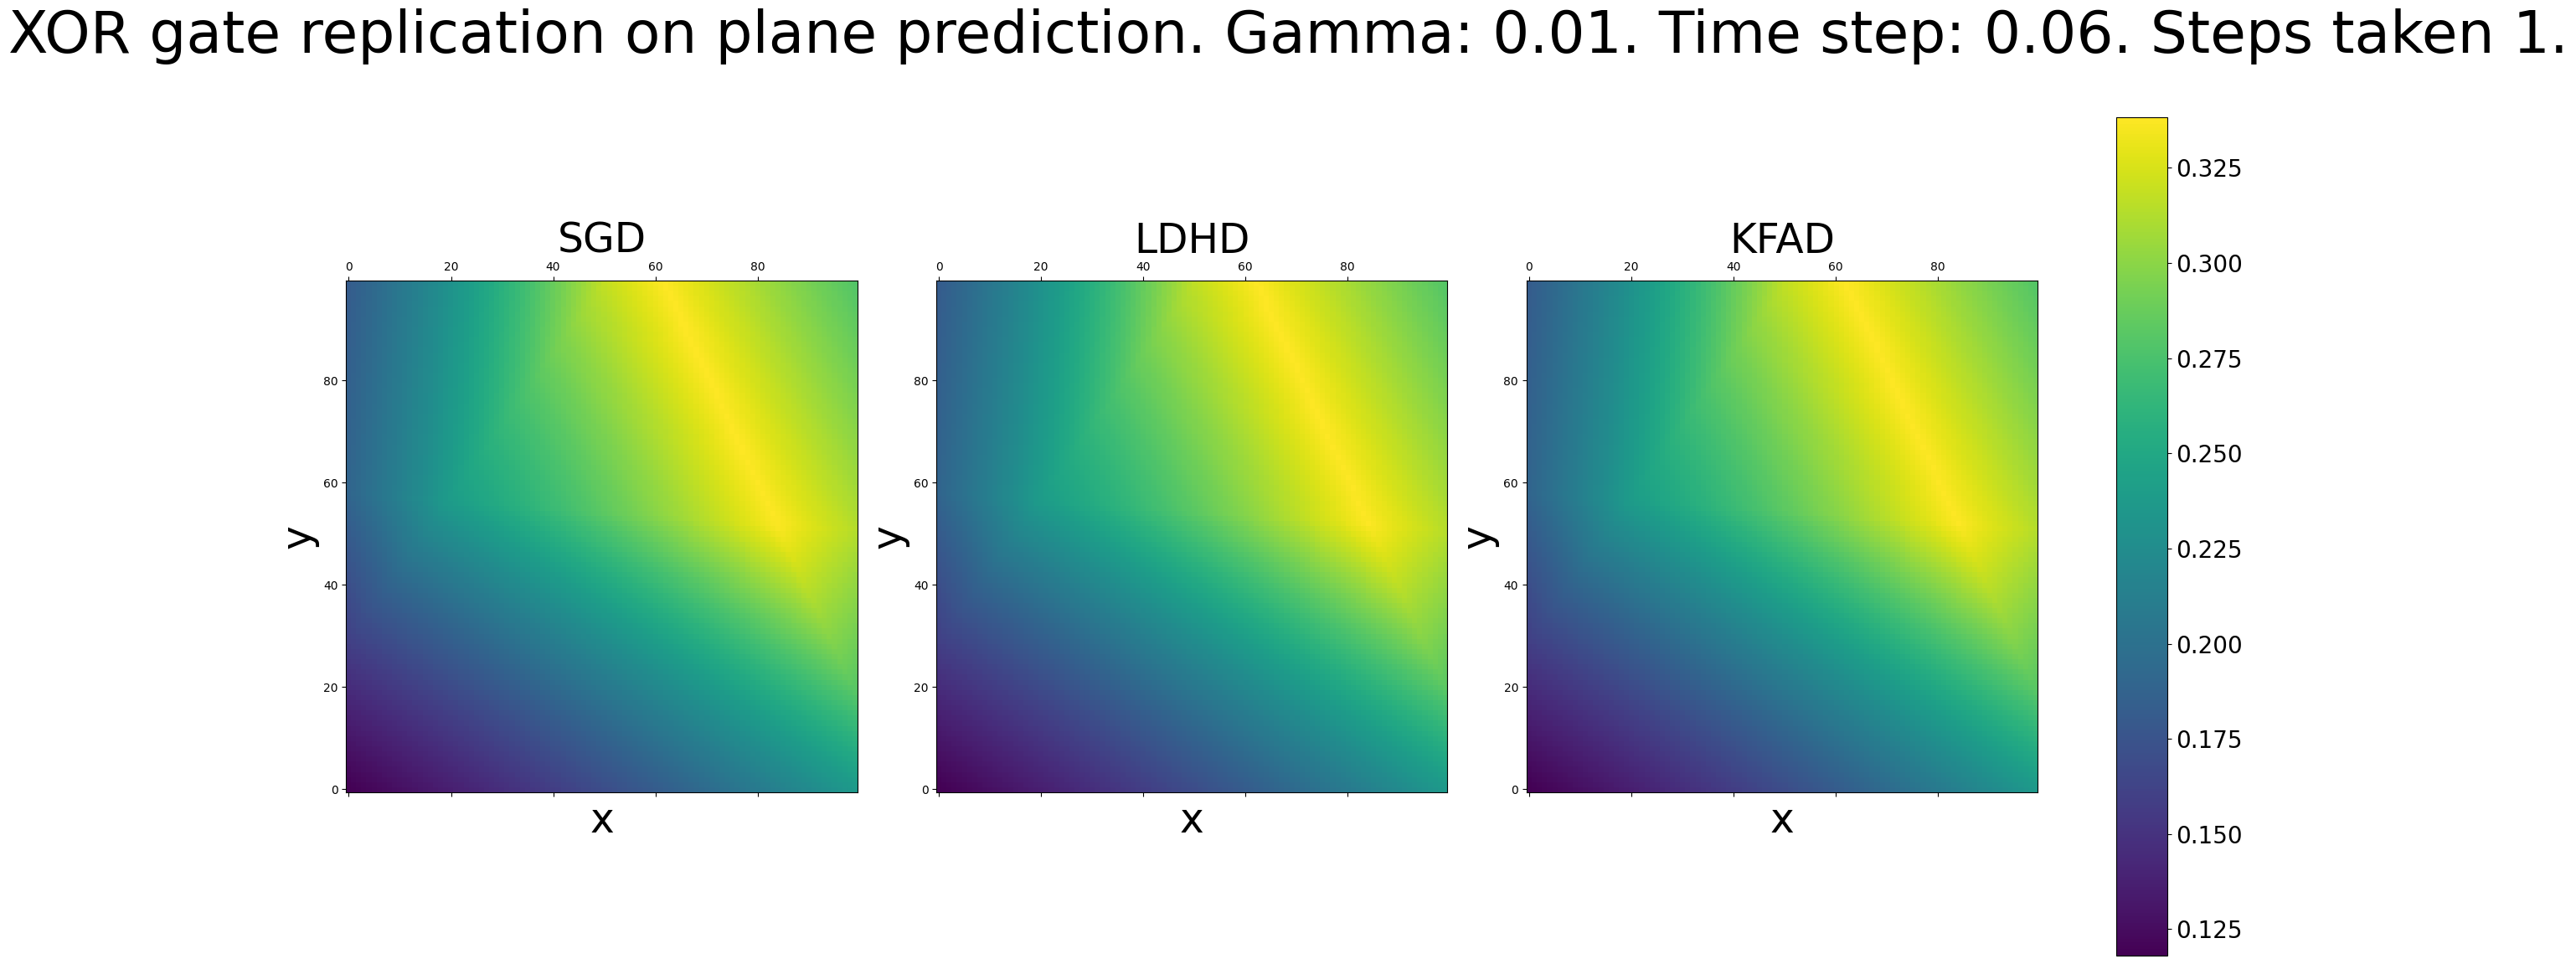

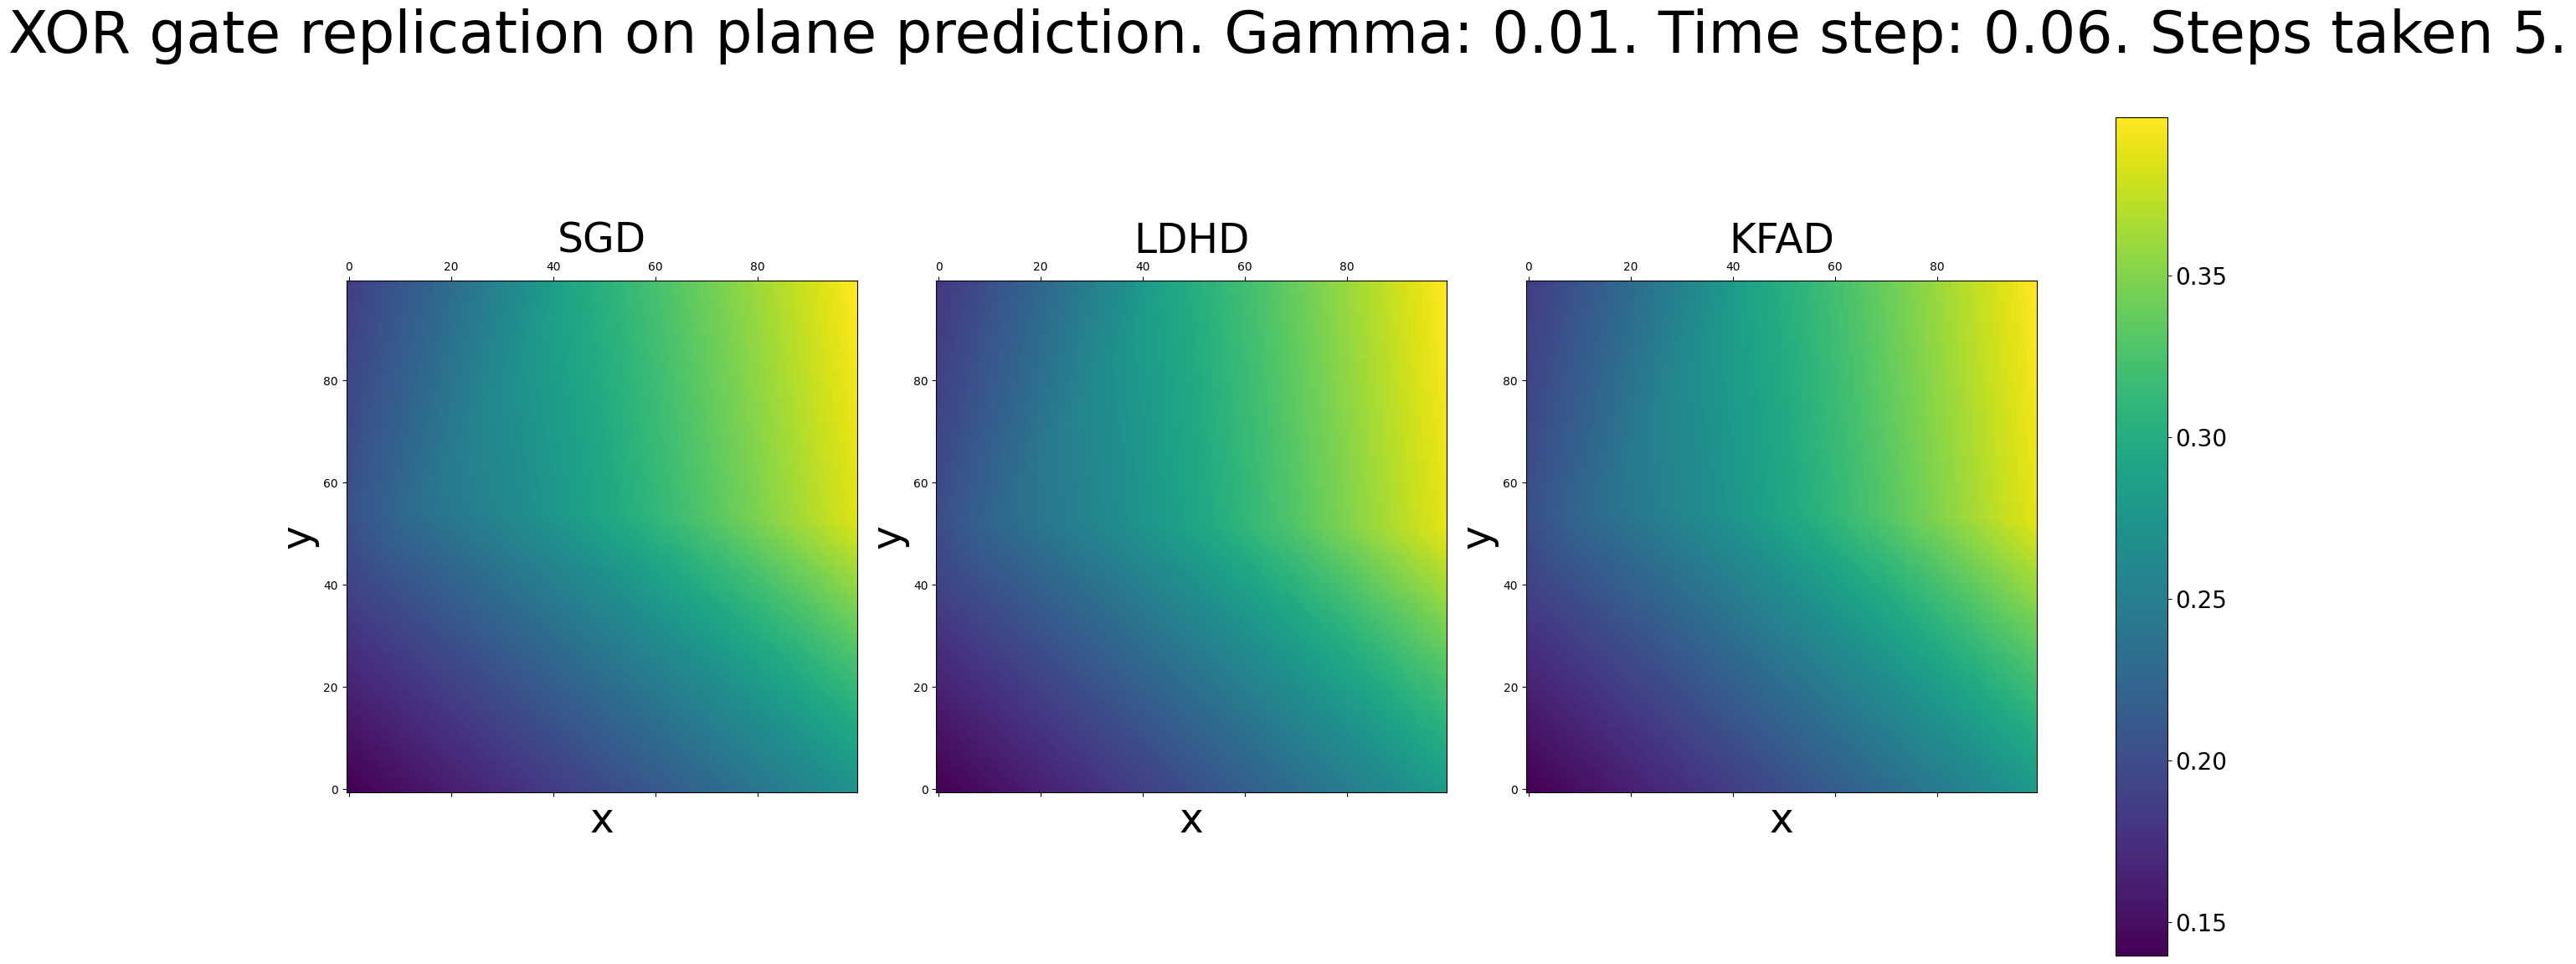

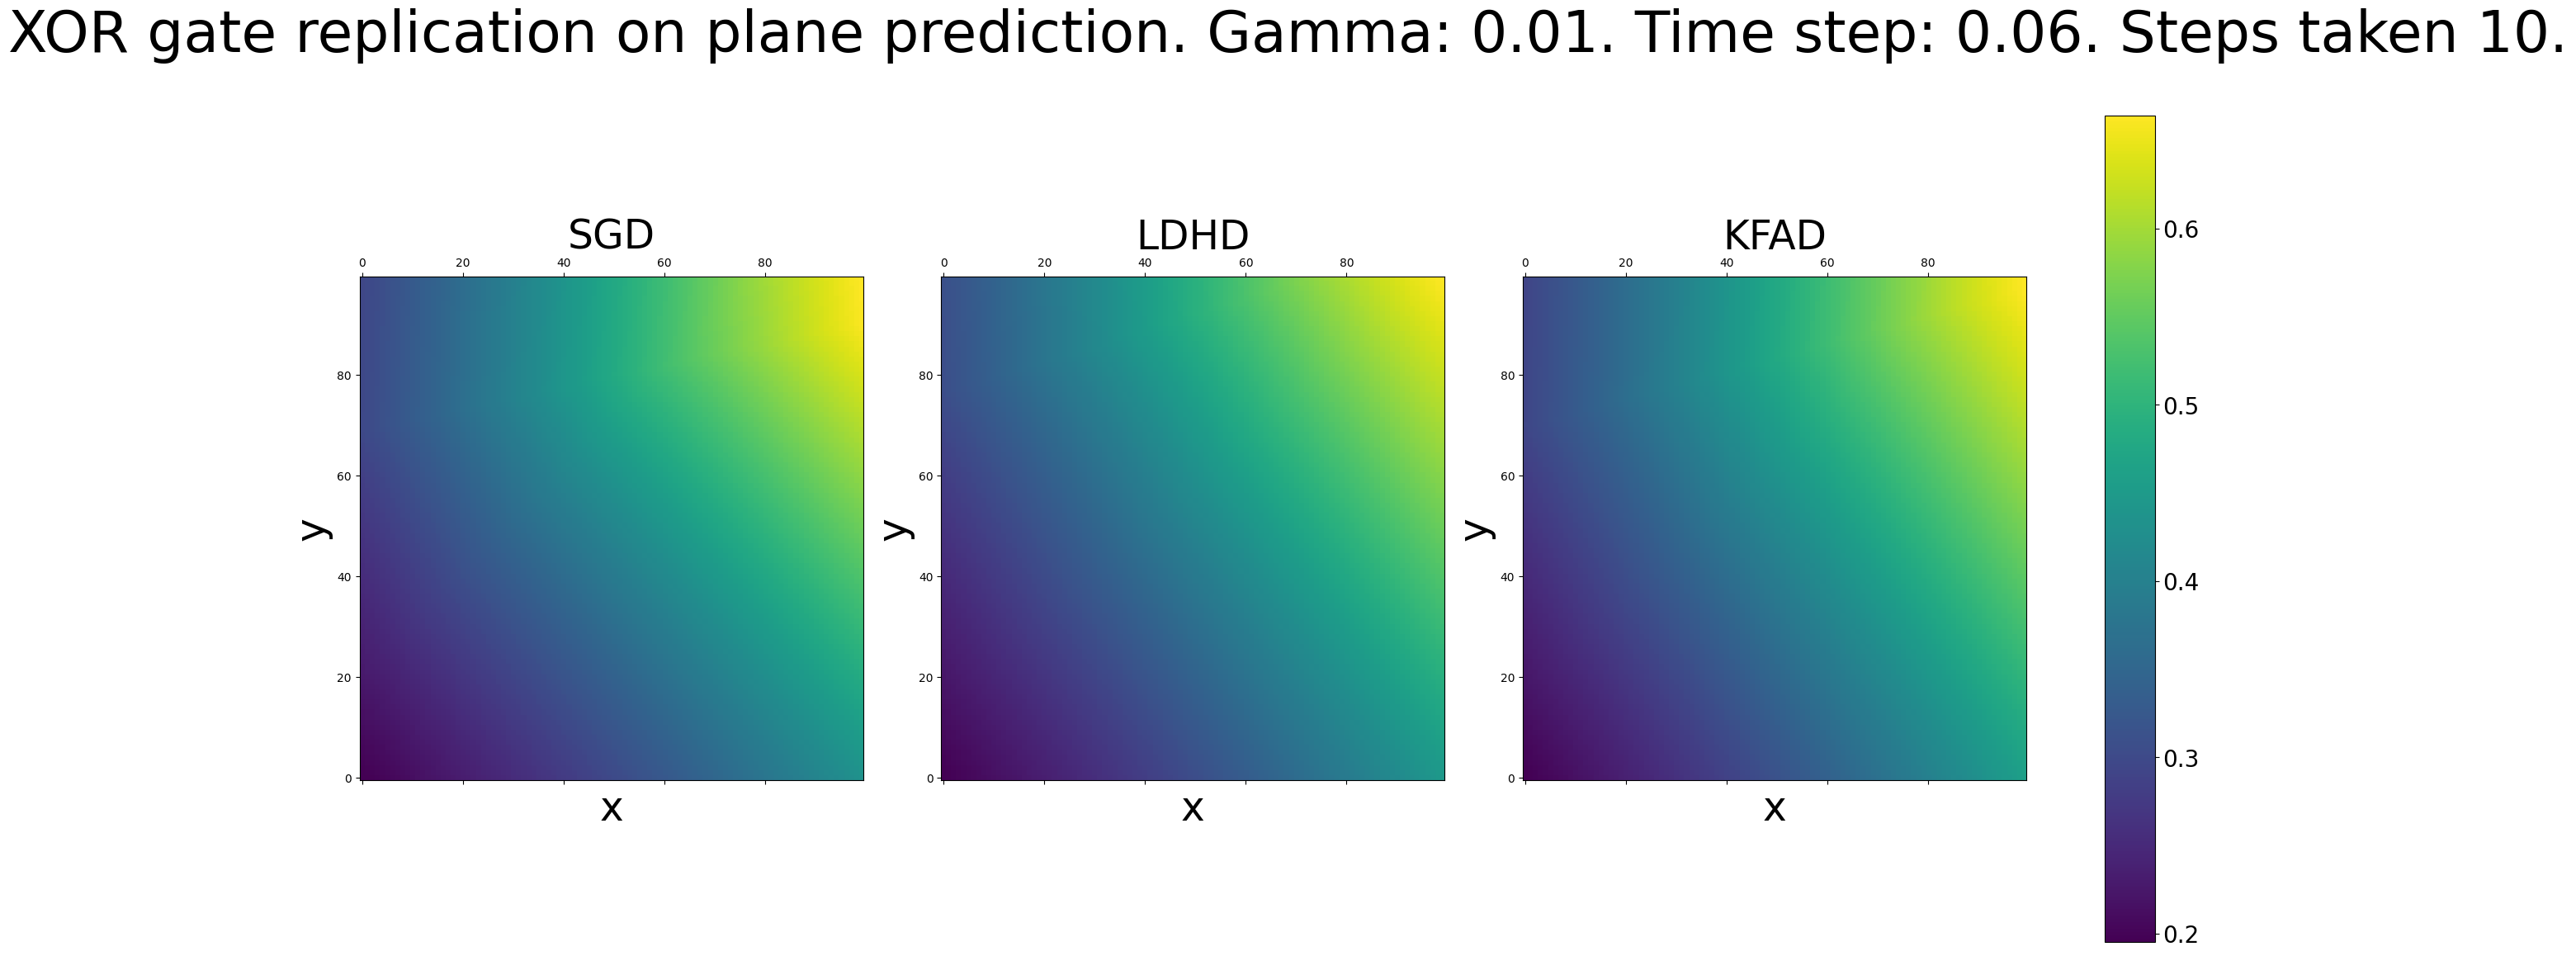

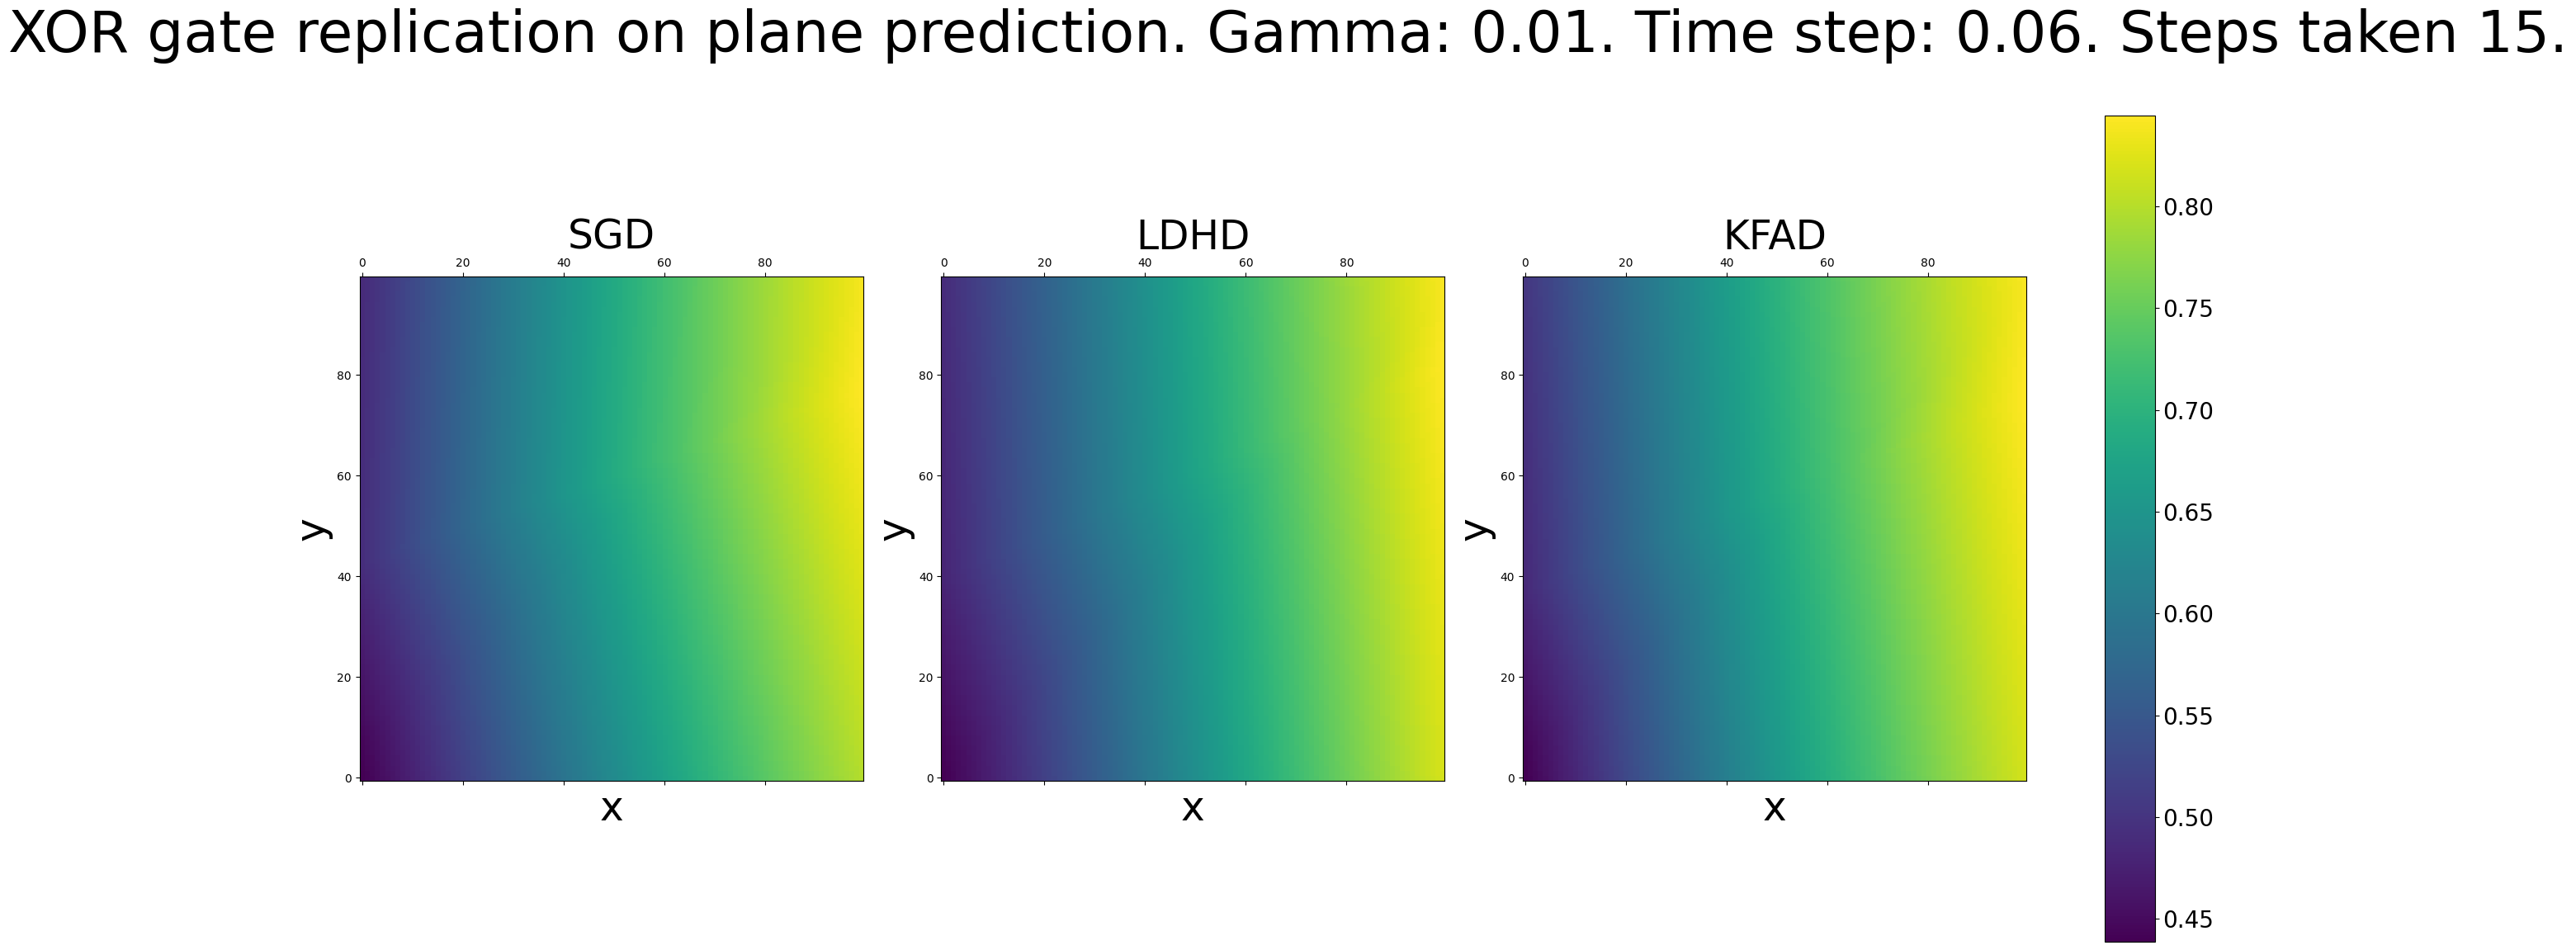

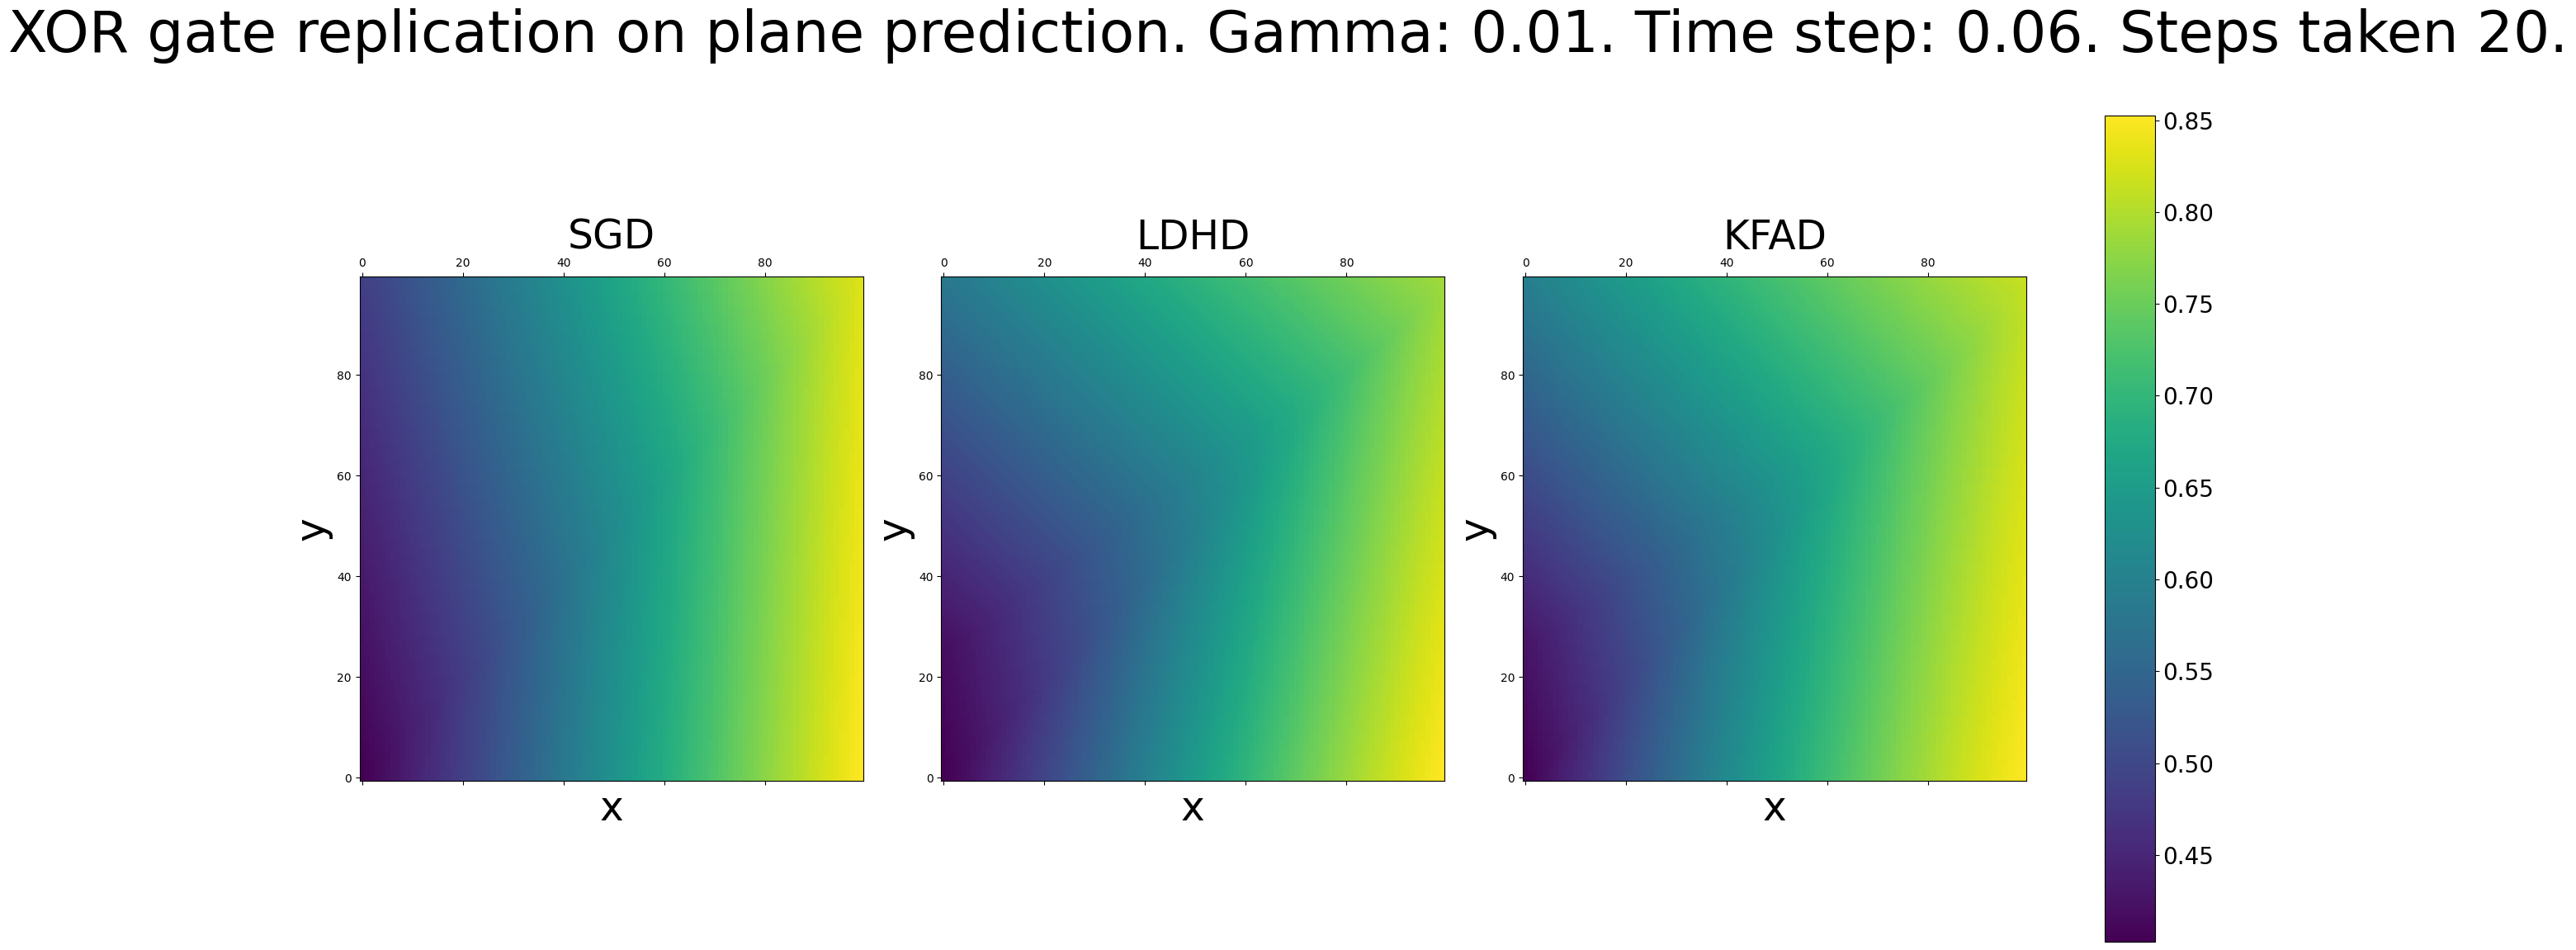

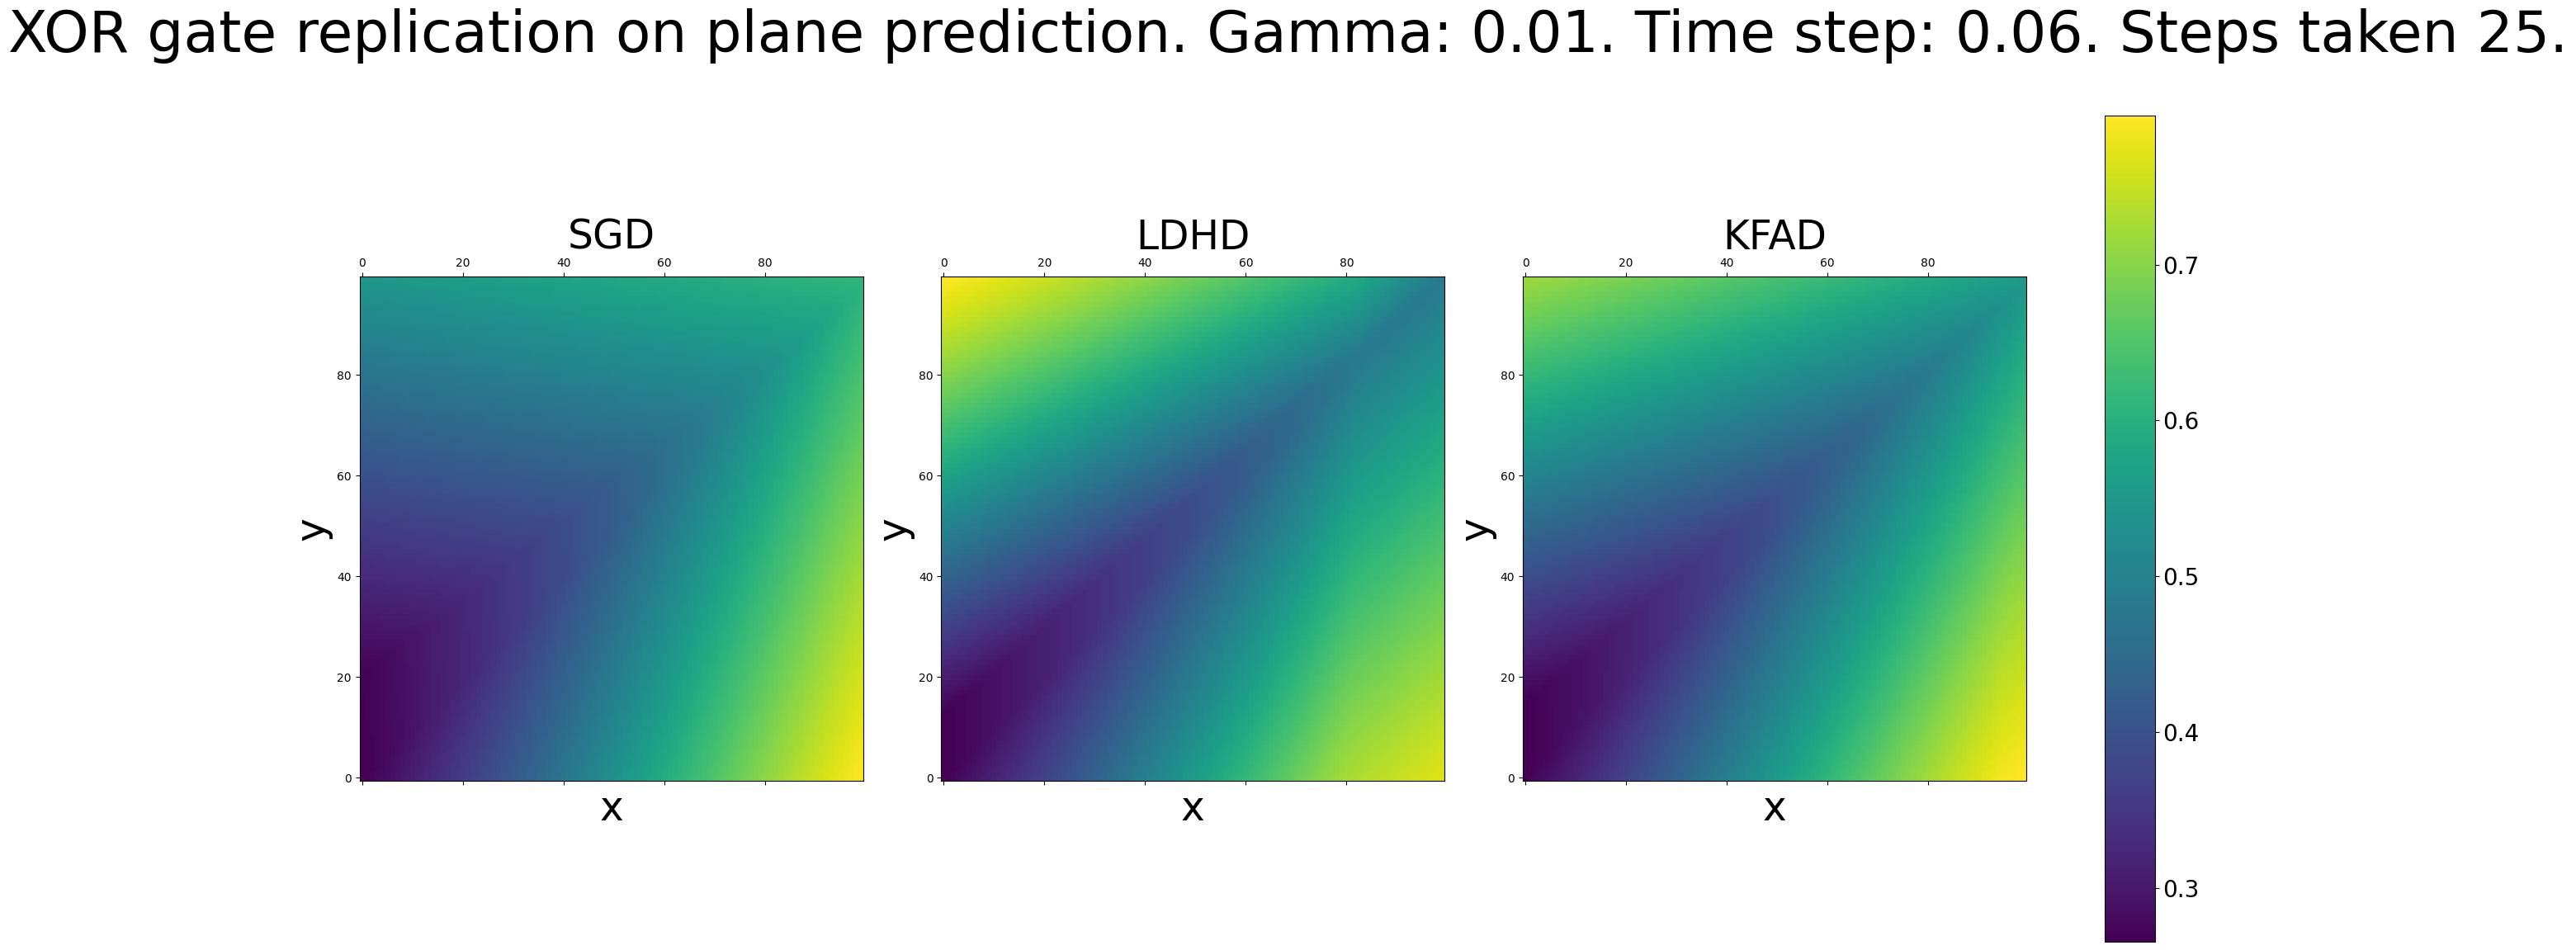

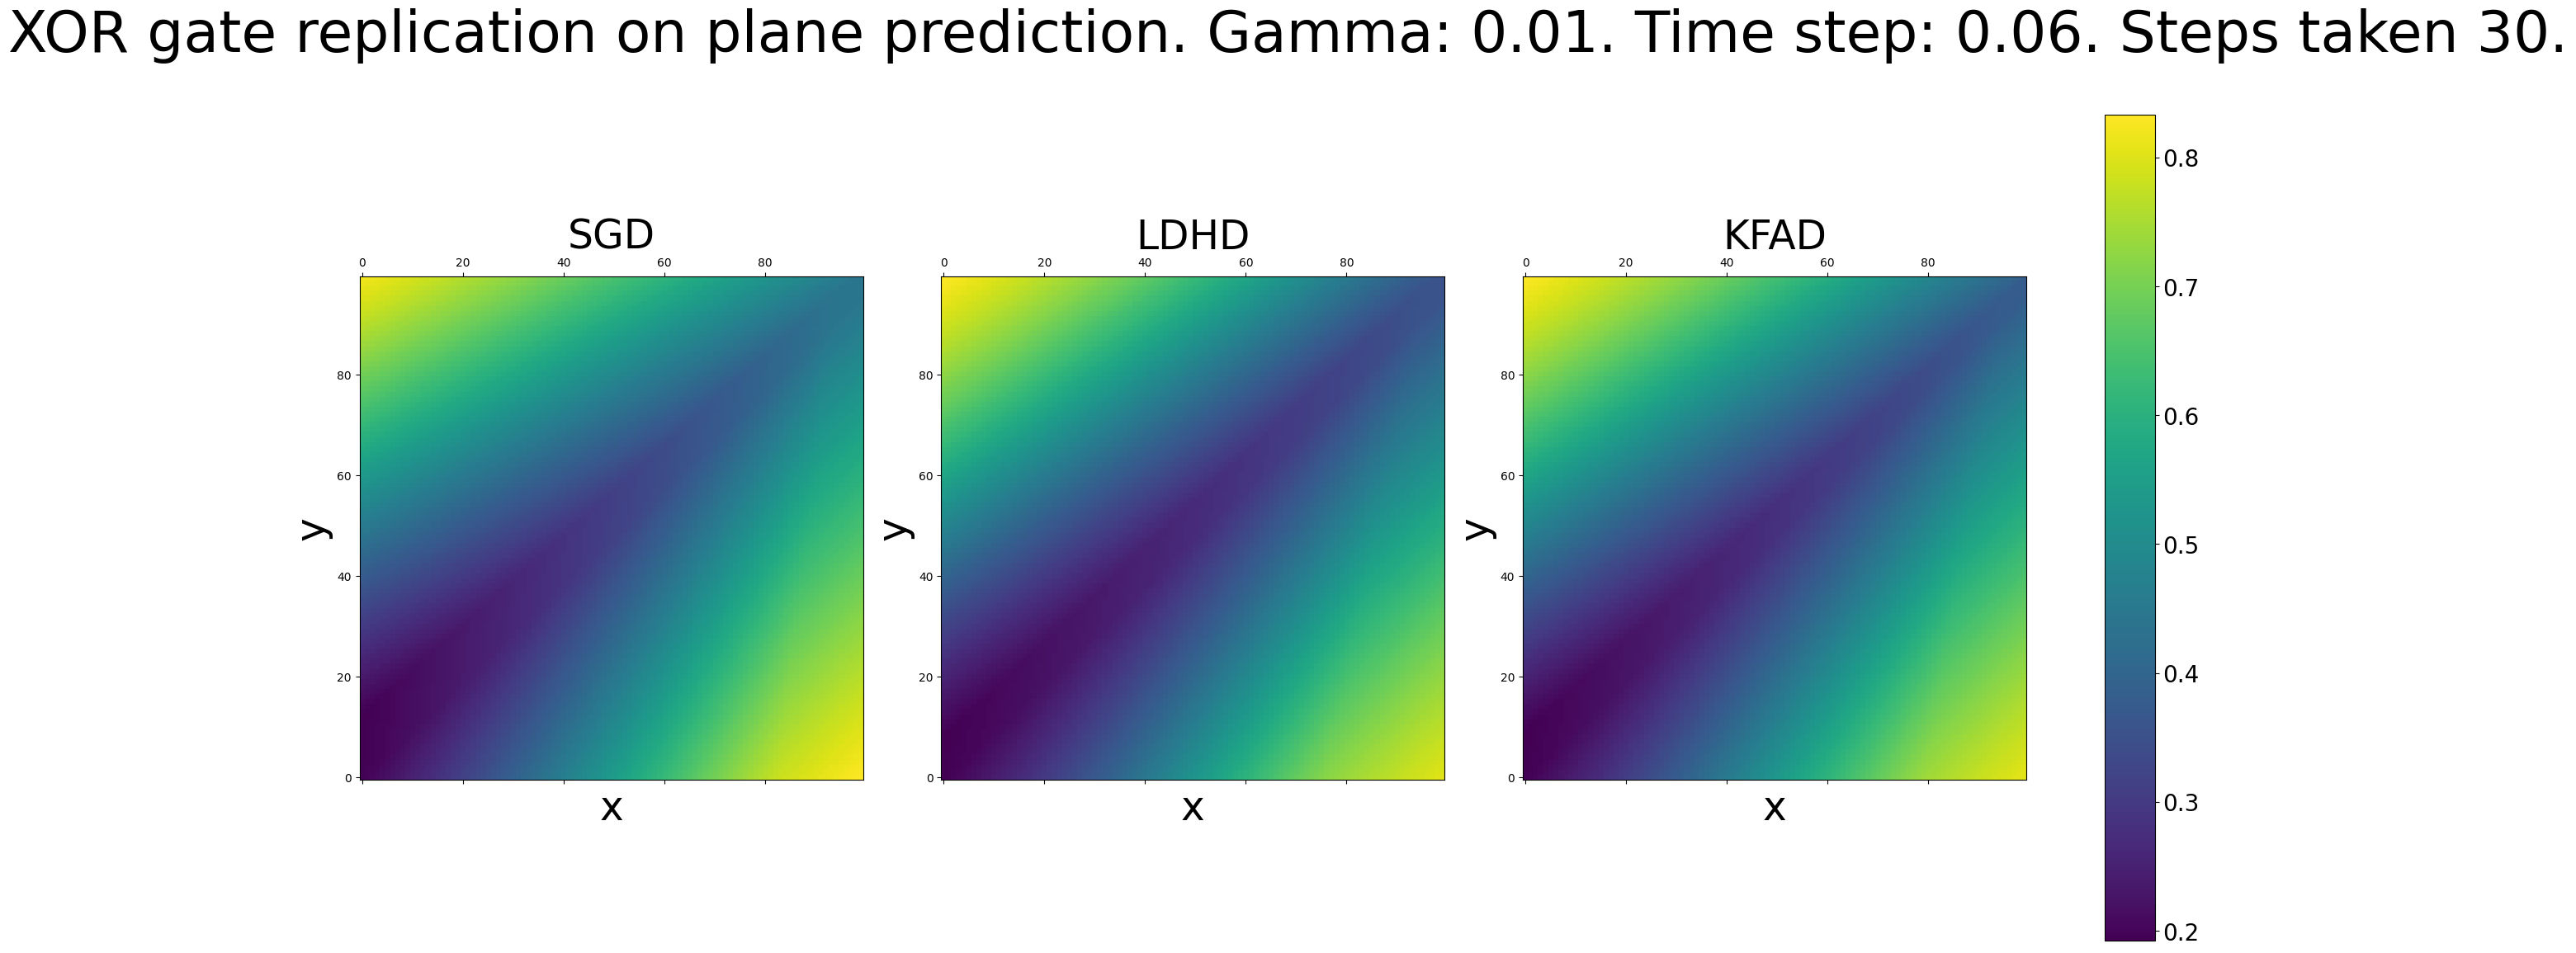

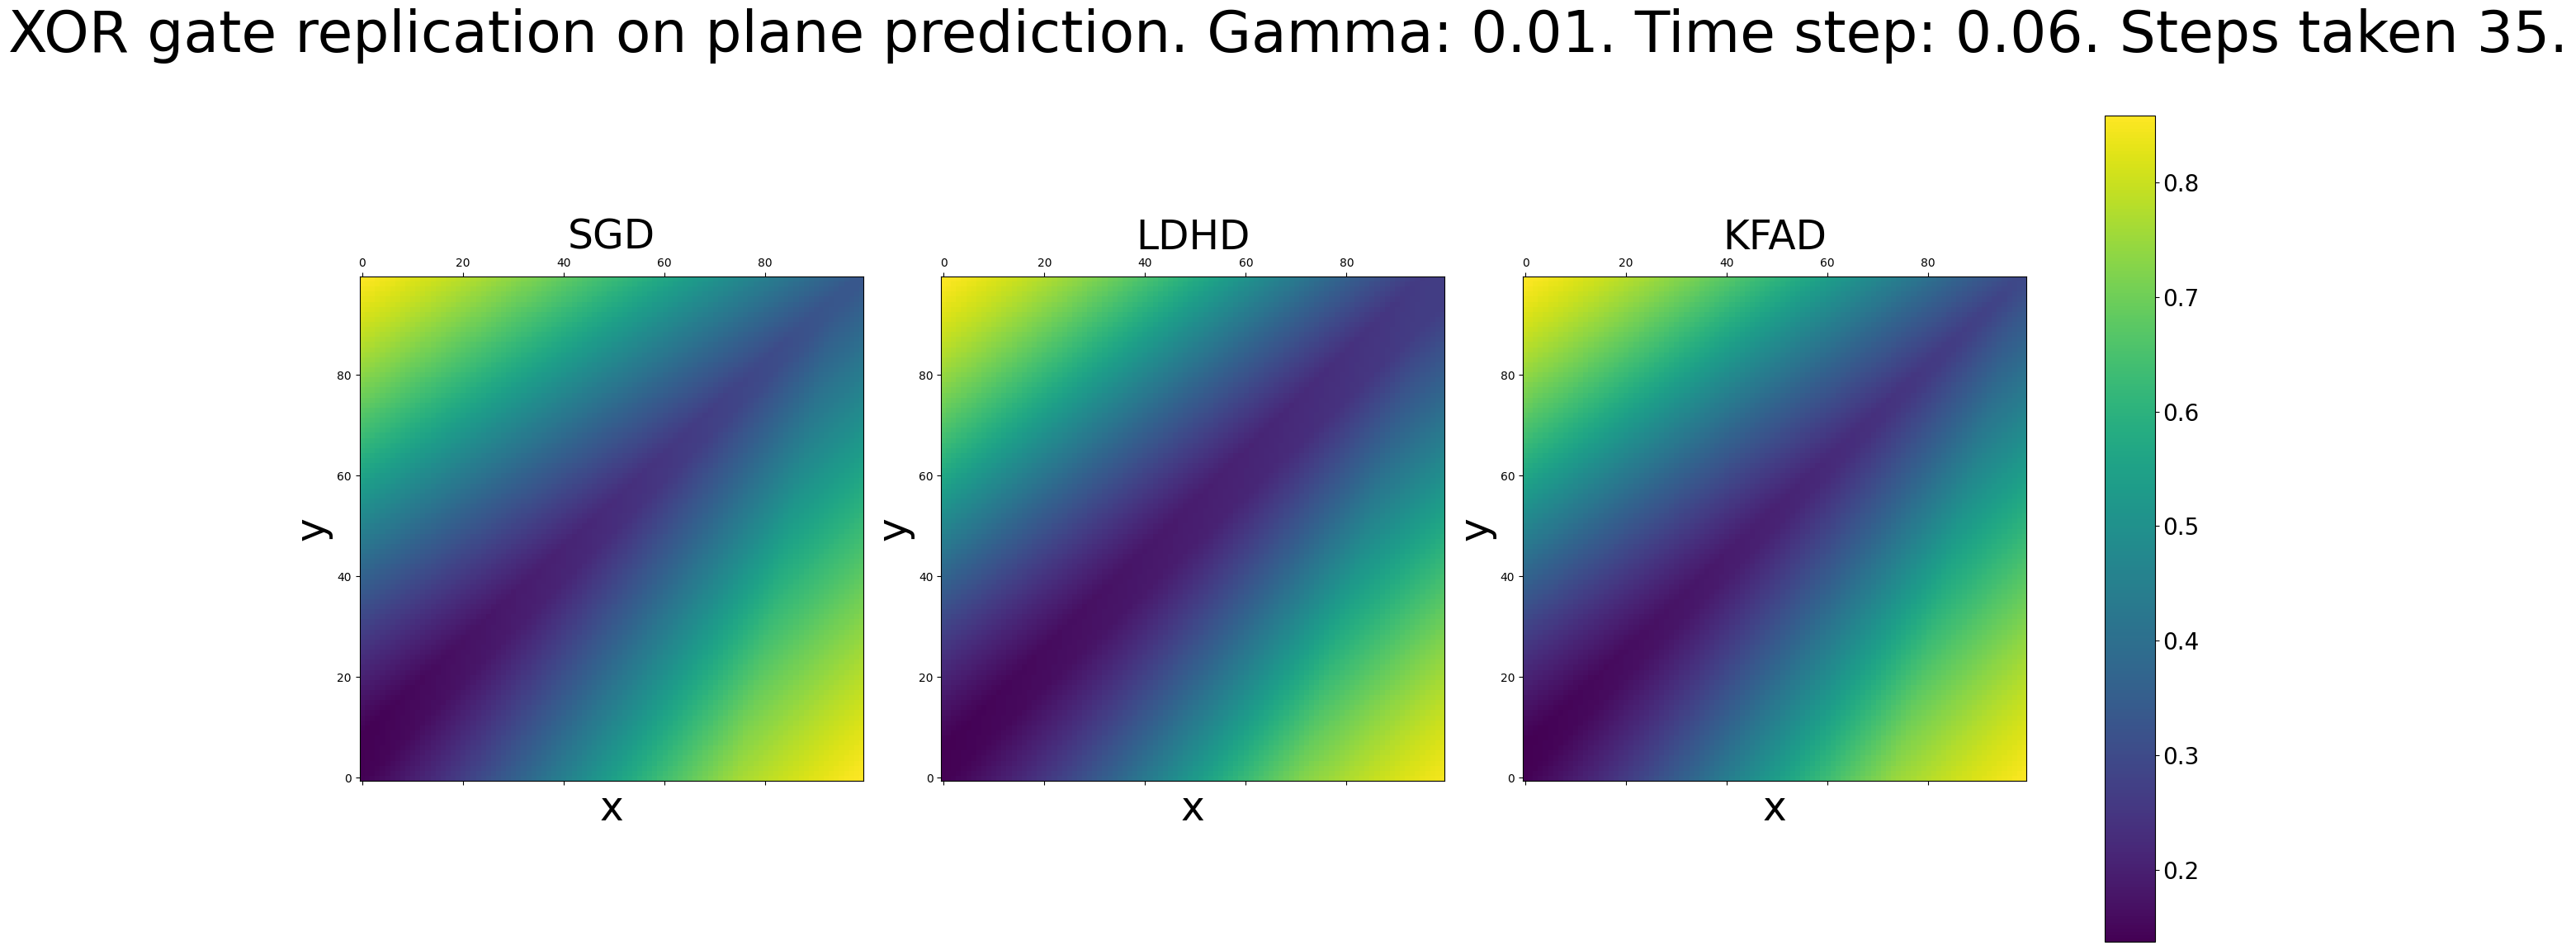

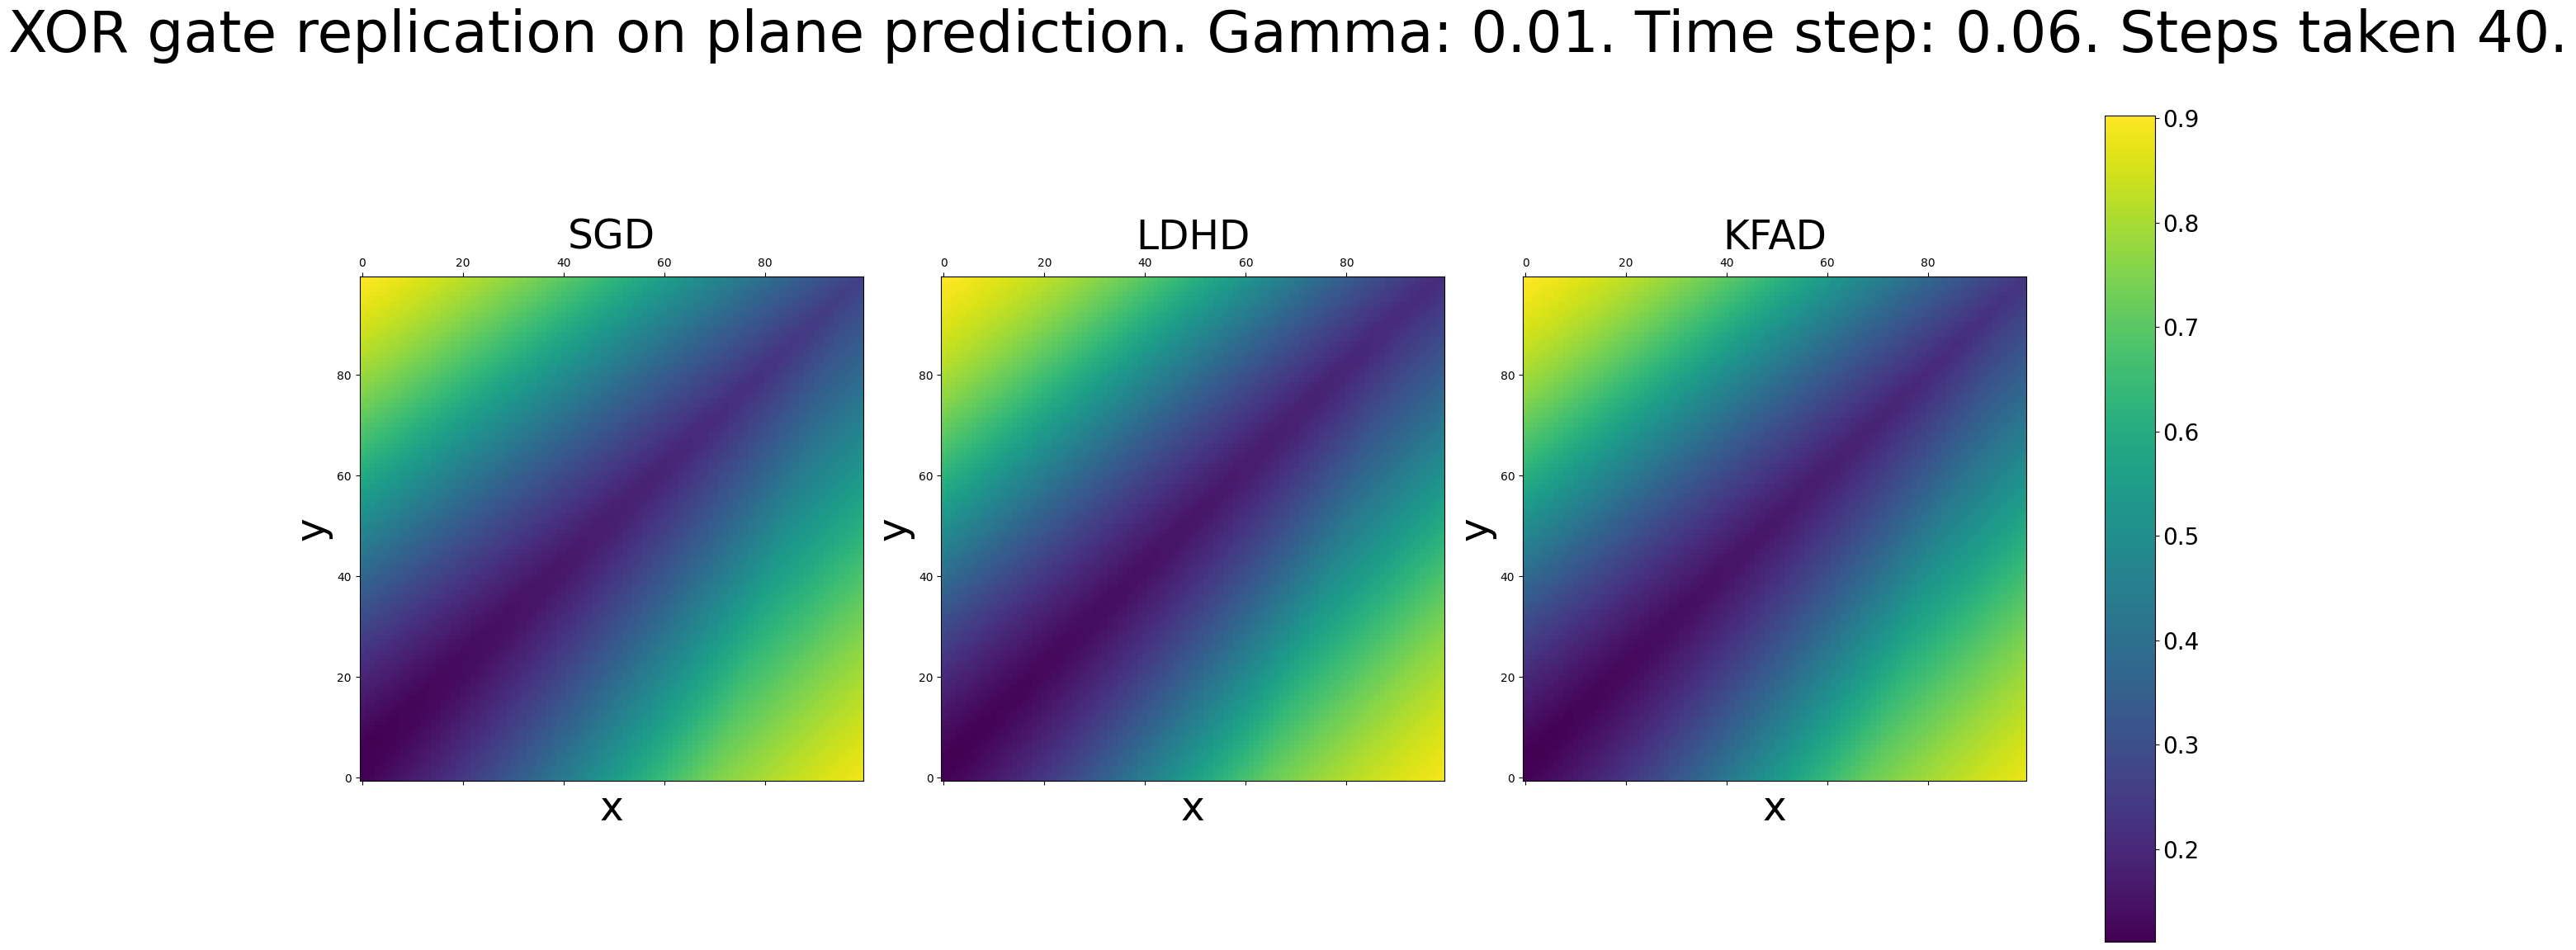

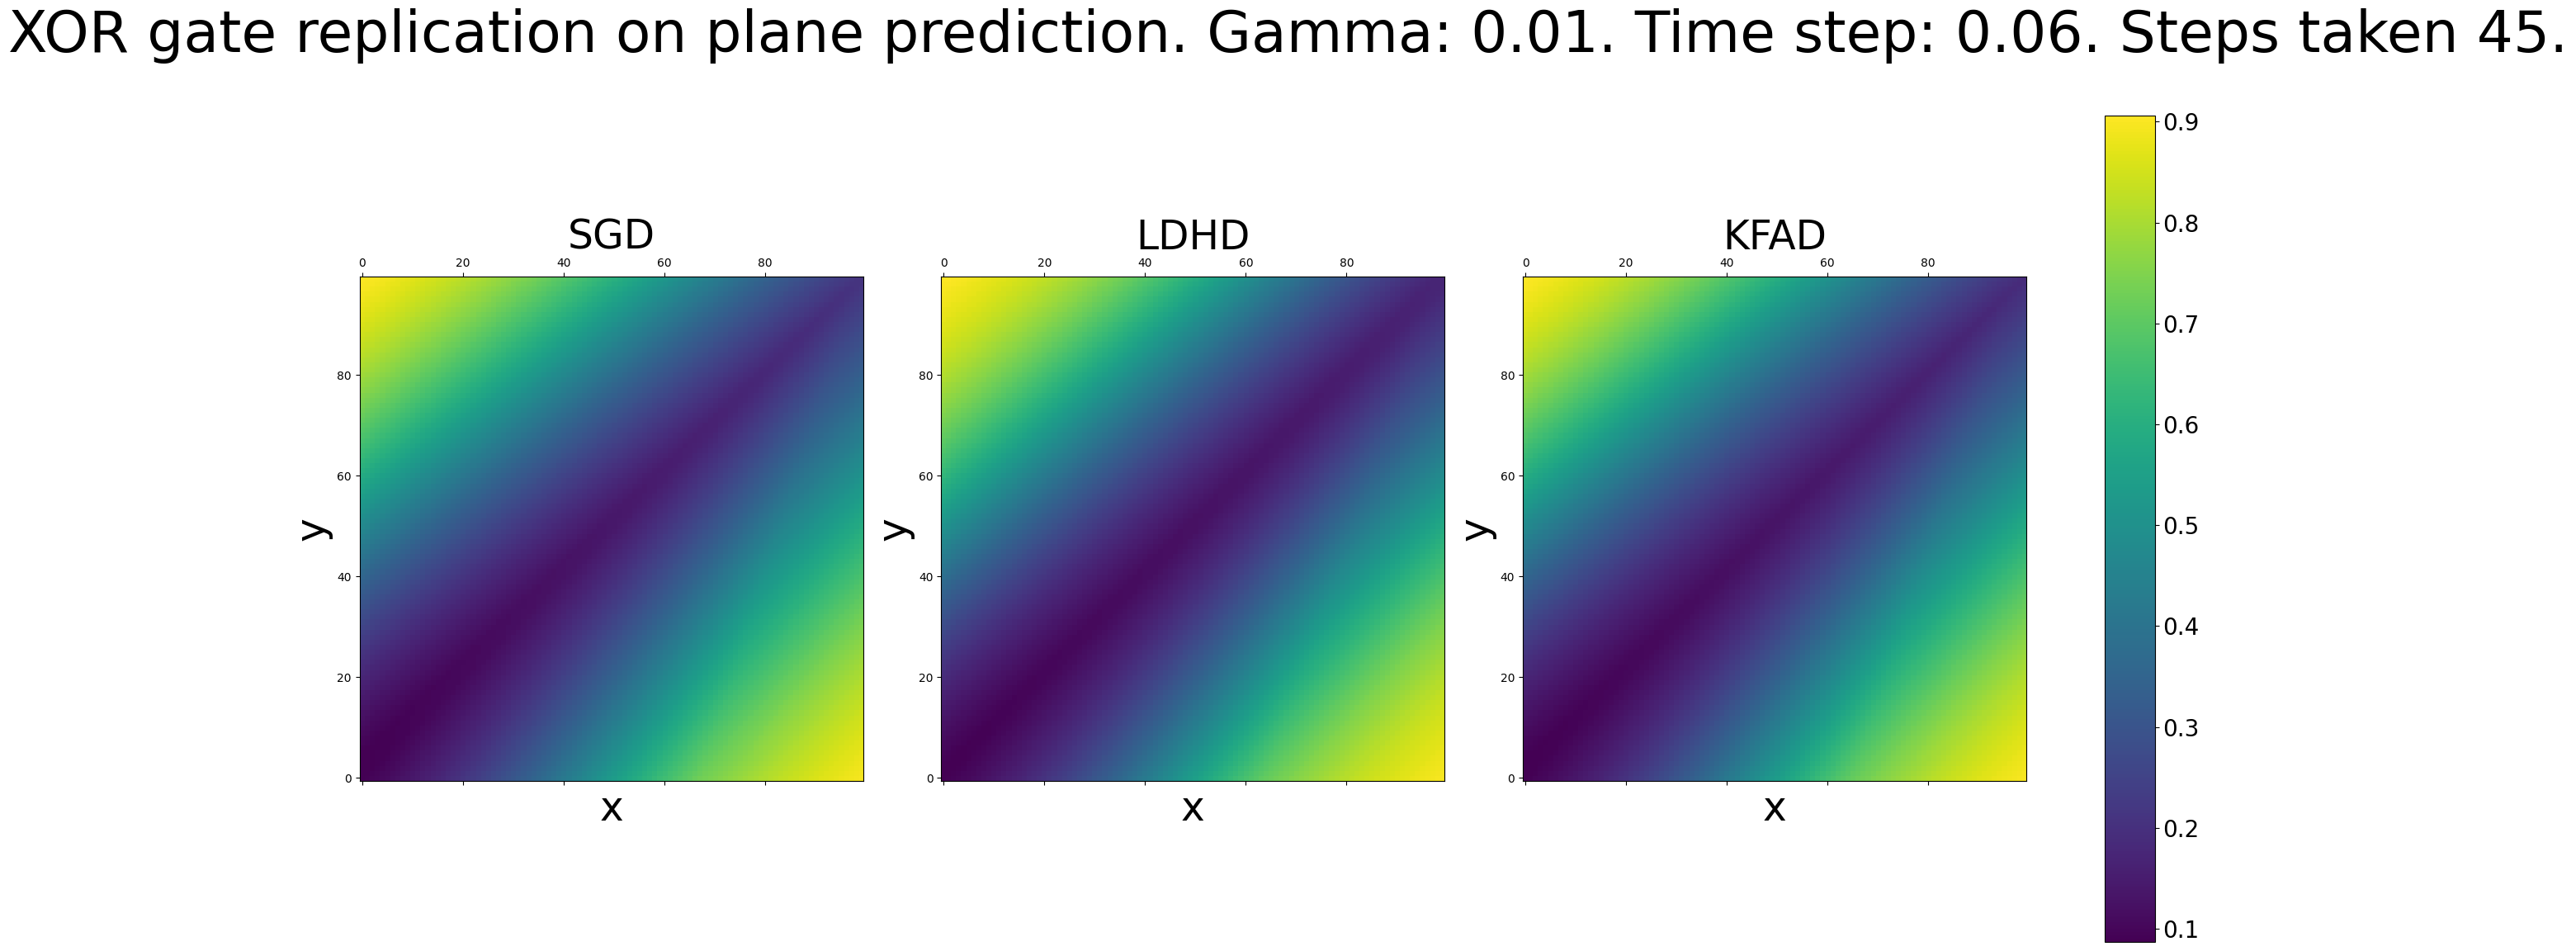

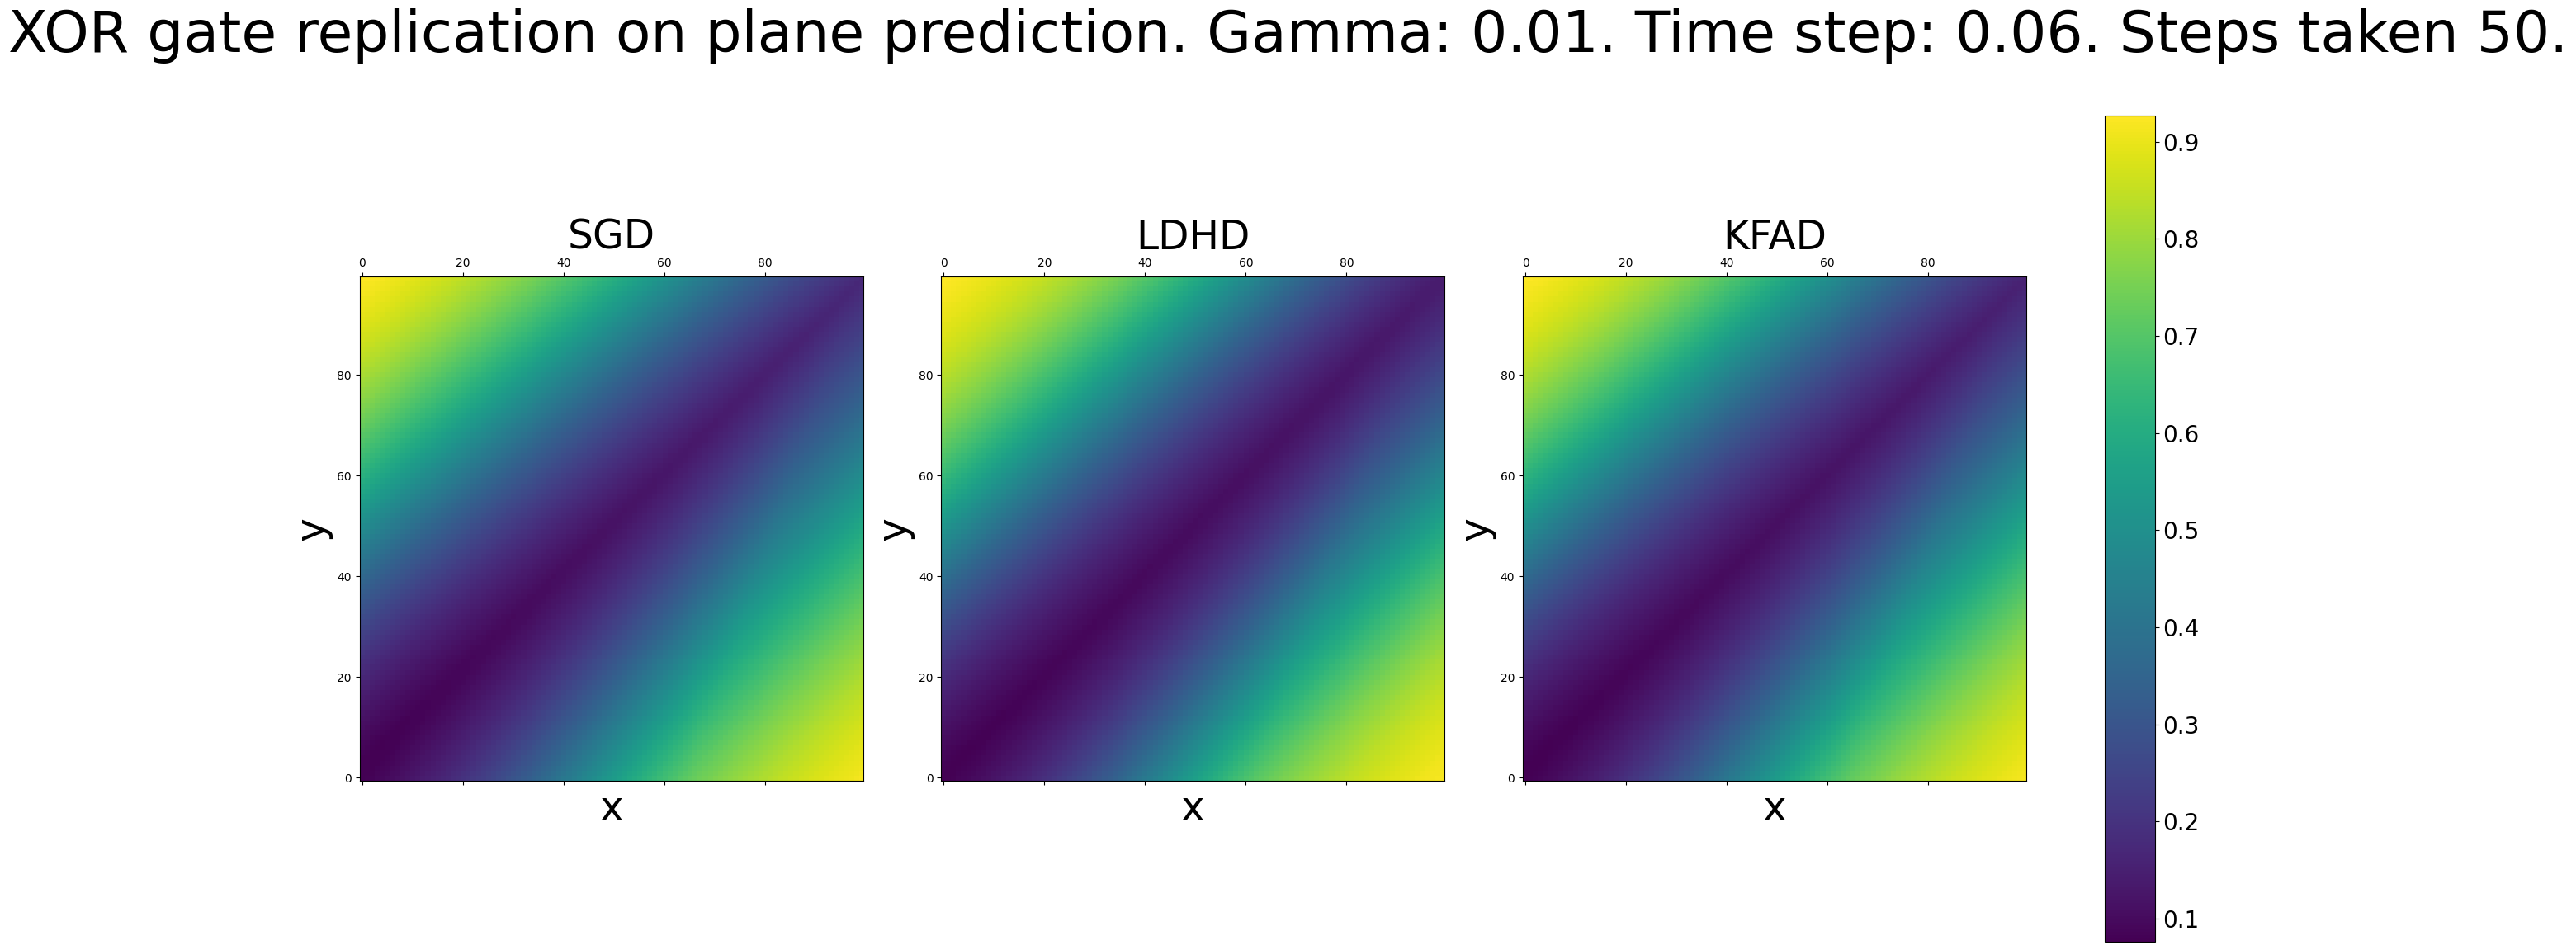

In [54]:
steps = [1,5, 10, 15, 20, 25, 30,35,40,45,50]


xor = NeuralNetwork(MSE,MSE_prime)
xor.add_layer(Layer(2,5))
xor.add_layer(ActivationLayer(relu, relu_prime))
xor.add_layer(Layer(5,1))
xor.add_layer(ActivationLayer(sigmoid, sigmoid_prime))
    
for step_num in steps:

    # plot
    fig, ax = plt.subplots(1,4,figsize=(30,13),width_ratios=[1,1,1,0.1])
    
    fig.suptitle(f"XOR gate replication on plane prediction. Gamma: {gamma}. Time step: {lr}. Steps taken {step_num}.", fontsize=50)
    
    for k in range(len(methods)):
        method = methods[k]
        # train the network
        xor.reset()
        xor.fit(X, y, step_num, batch_size, lr, method,extra_parameters=[gamma,None,None])
        predictions = xor.predict(plane)
        predictions = predictions.reshape(int(np.sqrt(plane.shape[0])),int(np.sqrt(plane.shape[0])),1)
        im = ax[k].matshow(predictions,  origin='lower')
        ax[k].set_xlabel('x', fontsize=35)
        ax[k].set_ylabel('y', fontsize=35)
        ax[k].set_title(method, fontsize=35)

    cbar = plt.colorbar(im, ax=ax.ravel().tolist(),fraction=0.05, cax=ax[3])
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(20)
    plt.subplots_adjust(right=0.85) 
    plt.savefig(f"./figures/XOR_MSE_plane_{step_num}.png", bbox_inches='tight', dpi=300)
    plt.show()

### Replicating an XOR-XOR gate

In [14]:
# Fixing the hyperparameters that we are not studying
Nsteps = 500
batch_size = 10
# alpha = 1
# mu = 1

# the training and test set for the XOR gate
X = np.array([[[0,0,0]],[[0,0,1]],[[0,1,0]],[[0,1,1]],[[1,0,0]],[[1,0,1]],[[1,1,0]],[[1,1,1]]])
y = np.array([[0],[1],[1],[0],[1],[0],[0],[1]])

xorxor = NeuralNetwork(MSE,MSE_prime)
xorxor.add_layer(Layer(3,5))
xorxor.add_layer(ActivationLayer(relu, relu_prime))
xorxor.add_layer(Layer(5,1))
xorxor.add_layer(ActivationLayer(sigmoid, sigmoid_prime))

# Testing all the methods
methods = ["SGD","LDHD","KFAD"]

# loss function plot
losses = {
    "SGD": np.zeros(Xsearch_timestep.shape),
    "LDHD": np.zeros(Xsearch_timestep.shape),
    "KFAD": np.zeros(Xsearch_timestep.shape)
}

np.zeros(Xsearch_timestep.shape)
for method in methods:
    for i in range(len(timesteps)):
        lr = timesteps[i]
        # the timestep of learning rate used in the network
        for j in range(len(gammas)):
            gamma = gammas[j]
            # the gamma used in the network
            # Create the neural network
            # The number of nodes in the hidden layer is set to 5 but this is arbitrary
            xorxor.reset()
            # train the network
            xorxor.fit(X, y, Nsteps, batch_size, lr, method,extra_parameters=[gamma,None,None])
            # prediction
            prediction = xorxor.predict(X)
            # store the loss
            loss = xorxor.loss(y, prediction)
            losses[method][j,i] = loss

In [16]:
# the above cell takes a long time to run so we store the dictionary where we have the losses
# for the XOR replication using MSE as the loss function
losses_dict_XORXOR = {
    "SGD": None,
    "LDHD": None,
    "KFAD": None
}
for i in range(len(methods)):
    losses_dict_XORXOR[methods[i]] = losses[methods[i]].tolist()

with open("XOR_MSE_16_XORXOR.json", "w") as outfile: 
    json.dump(losses_dict_XORXOR, outfile)

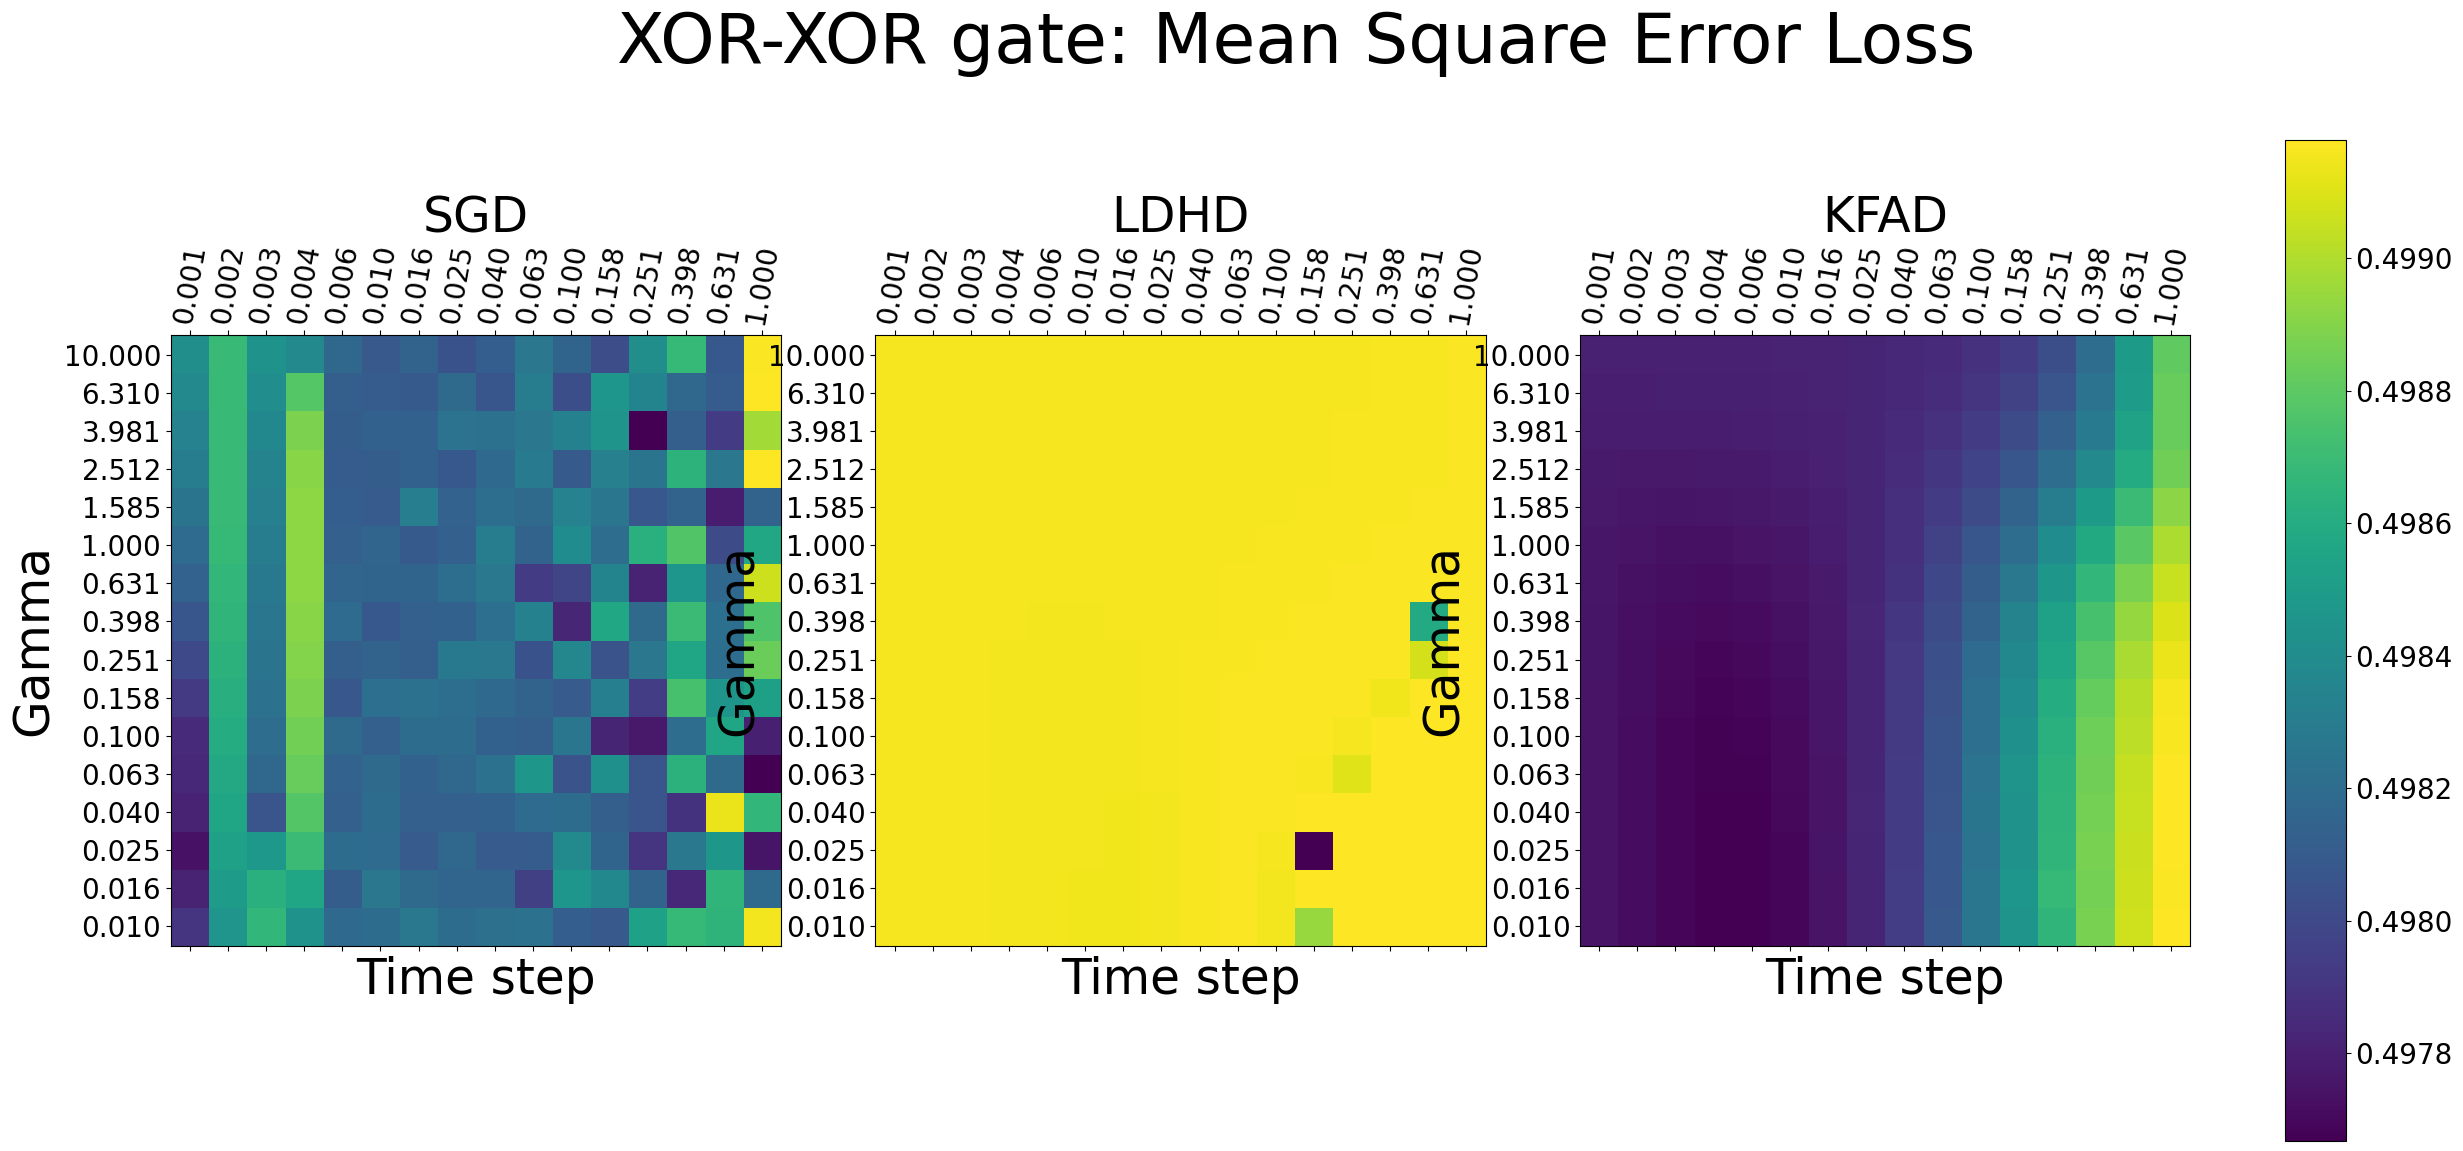

In [17]:
from matplotlib.ticker import FuncFormatter

# plot
fig, ax = plt.subplots(1,4,figsize=(30,13),width_ratios=[1,1,1,0.1])

fig.suptitle("XOR-XOR gate: Mean Square Error Loss", fontsize=50)
for k in range(len(methods)):
    method = methods[k]
    im = ax[k].matshow(losses[method],  origin='lower')
    ax[k].set_xlabel('Time step', fontsize=35)
    ax[k].set_ylabel('Gamma', fontsize=35)
    ax[k].set_title(method, fontsize=35)
    ax[k].set_xticks(np.arange(0,len(timesteps), step=1),labels=['{:.3f}'.format(x) for x in timesteps], rotation=80,fontsize=20)
    ax[k].set_yticks(np.arange(0,len(gammas), step=1), labels=['{:.3f}'.format(x) for x in gammas], fontsize=20)
    # ax[k].set_xticklabels(['']+['{:.3f}'.format(x) for x in timesteps], rotation=80,fontsize=12)
    # ax[k].set_yticklabels(['']+['{:.3f}'.format(x) for x in gammas], fontsize=12)

cbar = plt.colorbar(im, ax=ax.ravel().tolist(),fraction=0.05, cax=ax[3])

cbar.ax.tick_params(labelsize=20)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
def format_ticks(value, pos):
    magnitude = int(np.floor(np.log10(value)))
    scaled_value = value / 10**magnitude
    if magnitude == 0:
        return f'{scaled_value:.4f}'
    else:
        return f'{scaled_value:.4f}e{magnitude}'

# Set the custom formatter for the colorbar ticks
# cbar.formatter = FuncFormatter(format_ticks)
# cbar.update_ticks()
#plt.colorbar()
#plt.colorbar(cax)
plt.subplots_adjust(right=0.85) 
plt.savefig("/Users/analiacabello/Desktop/Y5/DISS/figures/XOR_MSE_16_try4.png", bbox_inches='tight', dpi=300)
plt.show()